# Notebook 2: Application d'analyse immobilière
---

**Projet développé par :**
- Ashley OHNONA
- Harisoa RANDRIANASOLO
- Fairouz YOUDARENE
- Jennifer ZAHORA

**Date :** 3/11/2025

---

## Présentation du projet
### Persona ciblé

#### Profil
- **Nom**: Marie
- **Age**: 40 ans
- **Occupation**: cadre supérieur à Paris

- **Budget**: 400-600k€

- **Objectif**: Acheter son premier bien locatif pour générer des revenus passifs

#### Besoins spécifiques
1. Avoir un aperçu clair du marché (prix au m2,tendances) (dashboard)
2. Identifier les villes avec le meilleur rendement locatif dans IDF
3. Comprendre quels types de biens sont les plus rentables (par département, par commune)
4. Comparer le potentiel de location simple vs coloc
5. Évaluer la liquidité du marché
6. Analyser des accessibilité des transports en commun (par département, par commune)
7. Vérifier la sécurité et l’attractivité du quartier
8. Trouver des biens accessibles avec son budget (par département, par commune)
9. Obtenir un classement des Top 10 opportunités actuelles (un tableau ou score automatique). 

---

## Objectifs de l'application
Identifier des territoires prometteurs pour un premier investissement locatif

---

## Sources de données
- DVF2024 : Demandes de valeurs foncières géolocalisées, [source](https://www.data.gouv.fr/datasets/demandes-de-valeurs-foncieres-geolocalisees/)
    - [full_2024.csv](https://files.data.gouv.fr/geo-dvf/latest/csv/2024/full.csv.gz)

- INSEE : Base officielle des communes françaises (INSEE / data.gouv.fr), [source](https://www.data.gouv.fr/datasets/communes-de-france-base-des-codes-postaux/)
    - [20230823-communes-departement-region.csv](https://www.data.gouv.fr/api/1/datasets/r/dbe8a621-a9c4-4bc3-9cae-be1699c5ff25)

- Transport : Île-de-France Mobilités — base officielle des points d’arrêt du réseau régional, [source](https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf/export/)
    - [emplacement-des-gares-idf.csv](https://data.iledefrance-mobilites.fr/api/explore/v2.1/catalog/datasets/emplacement-des-gares-idf/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B)

- Données Loyers : "Carte des loyers" - Indicateurs de loyers d'annonce par commune en 2024, [source](https://www.data.gouv.fr/datasets/carte-des-loyers-indicateurs-de-loyers-dannonce-par-commune-en-2024/)
    - [Loyer appartement](https://static.data.gouv.fr/resources/carte-des-loyers-indicateurs-de-loyers-dannonce-par-commune-en-2024/20241205-153050/pred-app-mef-dhup.csv)
    - [Loyer appartement T1-T2](https://static.data.gouv.fr/resources/carte-des-loyers-indicateurs-de-loyers-dannonce-par-commune-en-2024/20241205-153048/pred-app12-mef-dhup.csv)
    - [Loyer appartement T3+](https://static.data.gouv.fr/resources/carte-des-loyers-indicateurs-de-loyers-dannonce-par-commune-en-2024/20241205-145658/pred-app3-mef-dhup.csv)
    - [Loyer maison](https://static.data.gouv.fr/resources/carte-des-loyers-indicateurs-de-loyers-dannonce-par-commune-en-2024/20241205-145700/pred-mai-mef-dhup.csv)

- Données sécurité : Bases statistiques communale, départementale et régionale de la délinquance enregistrée par la police et la gendarmerie nationales, [source](https://www.data.gouv.fr/datasets/bases-statistiques-communale-departementale-et-regionale-de-la-delinquance-enregistree-par-la-police-et-la-gendarmerie-nationales)
    - [nom fichier](lien)

- Données activité : Dénombrement des équipements (commerce, sport, services, santé…), [source](https://catalogue-donnees.insee.fr/fr/catalogue/recherche/DS_BPE)
    - pas de lien direct
    - instructions de téléchargement

---

## Import des bibliothèques

In [1]:

# Manipulation et analyse de données
import pandas as pd
import numpy as np
import geopandas as gpd

# Visualisation statique
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation interactive
import plotly.express as px
import plotly.graph_objects as go

# Widgets et interactivité Jupyter
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from ipywidgets import Output, interact,IntSlider,Layout, Dropdown, Output, VBox, HBox, Button

# Cartographie interactive
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm

# Géométrie (utile pour GeoDataFrames)
from shapely.geometry import Point

---

### Chargement des données

In [ ]:
# --- Chargement des données nettoyées (préparées dans le Notebook 1) ---
# DVF
dvf_df = pd.read_csv('data/cleaned/dvf_idf_clean.csv')
dvf_df["valeur_fonciere"] = pd.to_numeric(dvf_df["valeur_fonciere"], errors="coerce") ## valeur_fonciere deja num

# Communes
#communes_df = pd.read_csv('data/cleaned/communes.csv')

# Indicateurs de loyer
loyers_df = pd.read_csv('data/cleaned/loyers_IDF_2024.csv')  ## already with latitude and longitude data
# loyer_predit deja num

#delinquance
delinq = pd.read_csv("data/cleaned/delinquance_nettoyes.csv")
#Attractivité(Equipements)
bpe = pd.read_csv("data/cleaned/bpe_nettoyes.csv")
# Transports
communes_gdf = gpd.read_file("data/cleaned/communes_coordonnees.geojson")
transports_gdf = gpd.read_file("data/cleaned/transports_nettoyes.geojson")


### Widget 1 :  Avoir un aperçu clair du marché (prix au m2,tendances) (dashboard)
- Widget  à part par ce que elle est faite sur streamlit

### **Widget 2 : Identifier les villes avec le meilleur rendement locatif dans IDF**

**Objectif rincipal**

Identifier les villes avec le meilleur rendement locatif en Île-de-France
Cette analyse permet de repérer les communes offrant les opportunités d'investissement immobilier les plus rentables en comparant les prix de vente avec les loyers estimés.


In [ ]:
# Création du df_rendement_brut
# ============================================================
def categorise_type_bien(row):
    """Helper function to categorise properties in dvf, according to how they are categorised for rent"""
    if row['type_local'] == 'Maison':
        return 'Maison'
    elif row['type_local'] == 'Appartement':
        if pd.isna(row['nombre_pieces_principales']) or row['nombre_pieces_principales'] == 0:
            return 'Appartement'
        elif row['nombre_pieces_principales'] <= 2:
            return 'Appartement T1-T2'
        elif row['nombre_pieces_principales'] >= 3:
            return 'Appartement T3+'
    return row['type_local']  # Fallback to original type if no condition matches

def merge_datasets(df1, df2, left="INSEE_COM", right="code_commune", on=None):
    """Fusion sur les codes INSEE"""
    if on is not None:
        df = df2.merge(df1, on=on, how="inner")
    else:
        df = df2.merge(df1, left_on=left, right_on=right, how="inner")
    return df

def merge_nom_commune_columns(df):
    """Merge nom_commune_x and nom_commune_y columns, keeping non-null values"""
    if 'nom_commune_x' in df.columns and 'nom_commune_y' in df.columns:
        df['nom_commune'] = df['nom_commune_x'].fillna(df['nom_commune_y'])
        df = df.drop(columns=['nom_commune_x', 'nom_commune_y'])
    return df

def create_dvf_rent_dataset(dvf_df, loyers_df):
    """Create merged dataset with DVF and rent data"""
    dvf_df['type_local'] = dvf_df.apply(categorise_type_bien, axis=1)
    display(dvf_df['type_local'].unique())

    # Aggregate by commune
    moyennes_df = dvf_df.groupby(['code_commune', 'type_local']).agg({
        'valeur_fonciere': 'mean',
        'surface_reelle_bati': 'mean',
        'id_mutation': 'count'
    }).reset_index().rename(columns={
        'valeur_fonciere': 'valeur_fonciere_moyenne',
        'surface_reelle_bati': 'surface_reelle_bati_moyenne',
        'id_mutation': 'nombre_mutations'
    })
    
    moyennes_df['prix_m2'] = moyennes_df['valeur_fonciere_moyenne'] / moyennes_df['surface_reelle_bati_moyenne']
    moyennes_df['code_commune'] = moyennes_df['code_commune'].astype(str)
    loyers_df['INSEE_COM'] = loyers_df['INSEE_COM'].astype(str)
    
    # Merge with rents
    merged_df = merge_datasets(loyers_df, moyennes_df, 
                               left=['code_commune', 'type_local'], 
                               right=['INSEE_COM', 'type_local'])
    merged_df = merged_df.drop(columns=['INSEE_COM'])
    
    return merged_df

def calculate_rendement_brut(df):
    """Calculate gross rental yield and years to payback"""
    df['loyer_annuel'] = df['loyer_predit_m2'] * df['surface_reelle_bati_moyenne'] * 12
    df['rendement_brut'] = (df['loyer_annuel'] / df['valeur_fonciere_moyenne']) * 100
    
    # Calculate years to payback (amortissement brut)
    df['annees_amortissement'] = 100 / df['rendement_brut']
    print('✓ Rendement brut par an, et années d\'amortissement calculés')
    return df


df_dvf_rent = create_dvf_rent_dataset(dvf_df, loyers_df)
df_dvf_rent = merge_nom_commune_columns(df_dvf_rent)
df_rendement_brut = calculate_rendement_brut(df_dvf_rent)

In [ ]:
# Outliers en rendement (> 20% par an)
# ============================================================
def create_outliers_table(df, column='rendement_brut', threshold=20):
    """Create and display a formatted table of outliers (rendements > threshold)"""
    # Filter for outliers (rendement > threshold)
    outliers = df[df[column] > threshold].copy()
    
    if len(outliers) == 0:
        print(f"✅ Aucun outlier détecté (rendement > {threshold}%)")
        return None
    
    # Sort by column value (descending)
    outliers = outliers.sort_values(by=column, ascending=False)
    
    # Prepare display columns
    display_cols = {
        'nom_commune': 'Commune',
        'DEP': 'Dép.',
        'type_local': 'Type',
        'rendement_brut': 'Rendement brut par an (%)',
        'annees_amortissement': 'Années d\'amortissement',
        'prix_m2': 'Prix/m² (€)',
        'loyer_predit_m2': 'Loyer/m² (€)',
        'nombre_mutations': 'Transactions'
    }
    
    # Select columns that exist
    cols_to_display = [col for col in display_cols.keys() if col in outliers.columns]
    result = outliers[cols_to_display].copy()
    result = result.rename(columns={k: v for k, v in display_cols.items() if k in cols_to_display})
    
    # Format numeric columns
    if 'Rendement brut par an (%)' in result.columns:
        result['Rendement brut par an (%)'] = result['Rendement brut par an (%)'].round(2)
    if 'Années d\'amortissement' in result.columns:
        result['Années d\'amortissement'] = result['Années d\'amortissement'].round(1)
    if 'Prix/m² (€)' in result.columns:
        result['Prix/m² (€)'] = result['Prix/m² (€)'].round(0).astype(int)
    if 'Loyer/m² (€)' in result.columns:
        result['Loyer/m² (€)'] = result['Loyer/m² (€)'].round(2)
    if 'Transactions' in result.columns:
        result['Transactions'] = result['Transactions'].astype(int)
    
    # Display results
    print(f"\n⚠️  OUTLIERS DÉTECTÉS (Rendement > {threshold}%)")
    print("=" * 120)
    print(f"Nombre d'outliers: {len(outliers)} sur {len(df)} observations ({len(outliers)/len(df)*100:.1f}%)\n")
    
    # Style and display
    styled_df = result.style.background_gradient(
        subset=['Rendement brut par an (%)'], 
        cmap='Reds',
        vmin=threshold,
        vmax=result['Rendement brut par an (%)'].max()
    ).format({
                'Rendement brut par an (%)': '{:.2f}%',
                'Années d\'amortissement': '{:.1f}',
                'Prix/m² (€)': '{:,.0f} €',
                'Loyer/m² (€)': '{:.2f} €',
                'Transactions': '{:,.0f}'
            })
    
    display(styled_df)
    
    # Statistics
    print(f"\n📊 Statistiques des outliers:")
    print(f"   • Rendement moyen: {outliers['rendement_brut'].mean():.2f}%")
    print(f"   • Rendement médian: {outliers['rendement_brut'].median():.2f}%")
    print(f"   • Rendement min: {outliers['rendement_brut'].min():.2f}%")
    print(f"   • Rendement max: {outliers['rendement_brut'].max():.2f}%")
    
    return result.reset_index(drop=True)

# Map creation functions
# ============================================================
def filter_data_by_yield(df, min_yield=None, max_yield=None):
    """Filter dataframe by yield range"""
    df_filtered = df.copy()
    
    if min_yield is not None:
        df_filtered = df_filtered[df_filtered['rendement_brut'] >= min_yield]
    if max_yield is not None:
        df_filtered = df_filtered[df_filtered['rendement_brut'] <= max_yield]
    
    return df_filtered

def prepare_map_data(df, communes_gdf):
    """Prepare data for map visualization"""
    
    # Merge data with commune coordinates
    df = df.merge(communes_gdf[['INSEE_COM', 'nom_commune', 'geometry']], 
                  left_on='code_commune', 
                  right_on='INSEE_COM', 
                  how='inner')
    
    try: 
        merge_nom_commune_columns(df)
    except Exception:
        pass

    # Convert to GeoDataFrame
    df = gpd.GeoDataFrame(df, geometry='geometry')
    
    # Extract base coordinates from geometry
    df['base_longitude'] = df.geometry.x
    df['base_latitude'] = df.geometry.y
    
    # Create offset based on type_local to separate markers
    # This prevents overlapping when multiple property types exist in same commune
    type_offsets = {
        'Maison': (0, 0),
        'Appartement T1-T2': (0.003, 0),
        'Appartement T3+': (-0.003, 0),
        'Appartement': (0, 0.003)
    }
    
    # Apply offset to coordinates
    df['longitude'] = df.apply(
        lambda row: row['base_longitude'] + type_offsets.get(row['type_local'], (0, 0))[0], 
        axis=1
    )
    df['latitude'] = df.apply(
        lambda row: row['base_latitude'] + type_offsets.get(row['type_local'], (0, 0))[1], 
        axis=1
    )
    
    # Clean data
    df = df.dropna(subset=['rendement_brut', 'latitude', 'longitude'])
    
    return df

def get_marker_color(rendement):
    """Get color based on yield value"""
    if rendement < 3:
        return "#C9CAD1"
    elif rendement < 5:
        return "#B29FD3"
    else:
        return "#222E6F"

def create_popup_html(row, color):
    """Create HTML popup for map marker"""
    # Use nom_commune if available, otherwise fallback to INSEE_COM
    commune = row.get('nom_commune', row.get('code_commune', 'Commune inconnue'))
    type_bien = row['type_local']
    rendement = row['rendement_brut']
    annees = row['annees_amortissement']
    
    # Add department number to commune name for clarity
    dept = row.get('DEP', '')
    if dept:
        commune_display = f"{commune} ({dept})"
    else:
        commune_display = commune
    
    popup_html = f"""
<div style="
    font-family: Arial, sans-serif;
    font-size: 13px;
    line-height: 1.5;
    border-radius: 10px;
    padding: 10px 15px;
    background-color: rgba(255,255,255,0.95);
    box-shadow: 0 2px 8px rgba(0,0,0,0.2);
    min-width: 200px;
    text-align: center;
">
    <h4 style="margin:0; color:{color}; font-size:15px;">
        🏙️ <b>{commune_display}</b>
    </h4>
    <p style="margin:3px 0; font-size:12px; color:#666;">
        {type_bien}
    </p>
    <hr style="border:none; border-top:1px solid #ddd; margin:6px 0;">
    
    <p style="margin:3px 0; font-size:13px;">
        💰 <b>Prix moyen :</b><br>
        <span style="font-weight:bold;">{row['prix_m2']:.0f} € / m²</span>
    </p>
    
    <p style="margin:3px 0; font-size:13px;">
        💶 <b>Loyer moyen :</b><br>
        <span style="font-weight:bold;">{row['loyer_predit_m2']:.2f} € / m²</span>
    </p>
    
    <p style="margin:3px 0; font-size:13px;">
        📈 <b>Rendement brut :</b><br>
        <span style="color:{color}; font-weight:bold; font-size:14px;">{rendement:.2f} %</span>
    </p>
    
    <p style="margin:3px 0; font-size:13px;">
        ⏱️ <b>Amortissement :</b><br>
        <span style="font-weight:bold;">{annees:.1f} ans</span>
    </p>
    
    <hr style="border:none; border-top:1px solid #ddd; margin:6px 0;">
    
    <p style="margin:3px 0; font-size:11px; color:#888;">
        📊 {int(row['nombre_mutations'])} transactions (vente)
    </p>
</div>
"""
    return popup_html

def create_legend_html(min_val, median_val, max_val, count):
    """Create HTML legend for map"""
    legend_html = f"""
<div style="
    position: fixed;
    top: 10px;
    left: 90%;
    transform: translateX(-50%);
    z-index: 9999;
    background-color: rgba(255,255,255,0.9);
    padding: 10px 20px;
    border-radius: 10px;
    box-shadow: 0 2px 6px rgba(0,0,0,0.3);
    font-size: 14px;
    text-align: center;
">
    <b>Rendement Brut (%)</b><br>
    <div style="width: 220px; height: 15px; background: linear-gradient(to right, #C9CAD1, #B29FD3, #222E6F); border-radius: 5px; margin: 5px 0;"></div>
    <div style="display: flex; justify-content: space-between; font-size: 12px;">
        <span>{min_val:.1f}%</span>
        <span>{median_val:.1f}%</span>
        <span>{max_val:.1f}%</span>
    </div>
    <p style="margin: 5px 0 0 0; font-size: 11px; color: #666;">
        Affichage : {count} communes
    </p>
</div>
"""
    return legend_html

def create_rental_yield_map(df_dvf_rent, communes_gdf, min_yield=None, max_yield=None):
    """Create an interactive map showing rental yields by commune and property type"""
    # Prepare and filter data
    df = prepare_map_data(df_dvf_rent, communes_gdf)
    df = filter_data_by_yield(df, min_yield, max_yield)
    
    # Check if we have data
    if len(df) == 0:
        print("⚠️ Aucune donnée à afficher avec les filtres actuels")
        return folium.Map(location=[48.8566, 2.3522], zoom_start=9, tiles="CartoDB positron")
    
    # Create base map
    m = folium.Map(
        location=[48.8566, 2.3522],
        zoom_start=9,
        tiles="CartoDB positron"
    )
    
    # Calculate statistics
    min_yield_display = df['rendement_brut'].min()
    max_yield_display = df['rendement_brut'].max()
    median_yield = df['rendement_brut'].median()
    
    # Add markers - now properly separated by type_local
    for _, row in df.iterrows():
        color = get_marker_color(row['rendement_brut'])
        popup_html = create_popup_html(row, color)
        coords = (row['latitude'], row['longitude'])  # Using the offset coordinates
        
        folium.CircleMarker(
            location=coords,
            radius=4,  # Slightly larger for better visibility
            color=color,
            weight=1,  # Add a small border
            fill=True,
            fill_color=color,
            fill_opacity=0.7,  # Slightly more opaque
            popup=folium.Popup(popup_html, max_width=250)
        ).add_to(m)
    
    # Add legend
    legend_html = create_legend_html(min_yield_display, median_yield, max_yield_display, len(df))
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

def create_rental_yield_map_with_clusters(df_dvf_rent, communes_gdf, min_yield=None, max_yield=None):
    """Create an interactive map with marker clustering"""
    # Prepare and filter data
    df = prepare_map_data(df_dvf_rent, communes_gdf)
    df = filter_data_by_yield(df, min_yield, max_yield)
    
    if len(df) == 0:
        print("⚠️ Aucune donnée à afficher avec les filtres actuels")
        return folium.Map(location=[48.8566, 2.3522], zoom_start=9, tiles="CartoDB positron")
    
    # Create base map
    m = folium.Map(
        location=[48.8566, 2.3522],
        zoom_start=9,
        tiles="CartoDB positron"
    )
    
    # Create marker cluster
    marker_cluster = MarkerCluster(
        name='Communes',
        overlay=True,
        control=True
    )
    
    # Calculate statistics
    min_yield_display = df['rendement_brut'].min()
    max_yield_display = df['rendement_brut'].max()
    median_yield = df['rendement_brut'].median()
    
    # Add markers with offsets
    for _, row in df.iterrows():
        color = get_marker_color(row['rendement_brut'])
        popup_html = create_popup_html(row, color)
        
        # Apply small offset based on type
        type_offsets = {
            'Maison': (0, 0),
            'Appartement T1-T2': (0.002, 0),
            'Appartement T3+': (-0.002, 0),
            'Appartement': (0, 0.002)
        }
        offset = type_offsets.get(row['type_local'], (0, 0))
        coords = (row['latitude'] + offset[1], row['longitude'] + offset[0])
        
        folium.CircleMarker(
            location=coords,
            radius=7,
            color=color,
            weight=1,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=folium.Popup(popup_html, max_width=250)
        ).add_to(marker_cluster)
    
    marker_cluster.add_to(m)
    
    custom_css = """
    <style>
        .marker-cluster-small {
            background-color: rgba(242, 168, 109, 0.6) !important;
        }
        .marker-cluster-small div {
            background-color: rgba(242, 168, 109, 0.8) !important;
            color: white !important;
        }
        
        .marker-cluster-medium {
            background-color: rgba(242, 168, 109, 0.6) !important;
        }
        .marker-cluster-medium div {
            background-color: rgba(242, 168, 109, 0.8) !important;
            color: white !important;
        }
        
        .marker-cluster-large {
            background-color: rgba(242, 168, 109, 0.6) !important;
        }
        .marker-cluster-large div {
            background-color: rgba(242, 168, 109, 0.8) !important;
            color: white !important;
        }
    </style>
    """
    m.get_root().html.add_child(folium.Element(custom_css))
    
    # Add legend
    legend_html = create_legend_html(min_yield_display, median_yield, max_yield_display, len(df))
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# INTERACTIVE WIDGETS
# ============================================================
def create_interactive_map(df_dvf_rent, communes_gdf):
    """
    Create an interactive map with sliders to filter by rental yield range.
    Also displays outliers table before the map.
    """
    # Calculate min and max yields
    min_possible = df_dvf_rent['rendement_brut'].min()
    max_possible = df_dvf_rent['rendement_brut'].max()
    
    # Create output widgets
    outliers_output = Output()
    map_output = Output()
    
    # Create slider widgets
    min_slider = widgets.FloatSlider(
        value=min_possible,
        min=min_possible,
        max=max_possible,
        step=0.1,
        description='Min (%):',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        style={'description_width': '80px'}
    )
    
    max_slider = widgets.FloatSlider(
        value=max_possible,
        min=min_possible,
        max=max_possible,
        step=0.1,
        description='Max (%):',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        style={'description_width': '80px'}
    )
    
    reset_button = widgets.Button(
        description='Réinitialiser',
        button_style='warning',
        tooltip='Réinitialiser les filtres',
        icon='refresh'
    )
    
    # Function to update displays
    def update_display(change=None):
        # Update outliers table
        with outliers_output:
            clear_output(wait=True)
            create_outliers_table(df_dvf_rent, column='rendement_brut', threshold=20)
        
        # Update map
        with map_output:
            clear_output(wait=True)
            
            min_val = min_slider.value
            max_val = max_slider.value
            
            # Ensure min < max
            if min_val > max_val:
                min_val, max_val = max_val, min_val
                min_slider.value = min_val
                max_slider.value = max_val
            
            # m = create_rental_yield_map(df_dvf_rent, communes_gdf, min_val, max_val)
            m = create_rental_yield_map_with_clusters(df_dvf_rent, communes_gdf, min_val, max_val)
            display(m)
    
    # Function to reset filters
    def reset_filters(b):
        min_slider.value = min_possible
        max_slider.value = max_possible
    
    # Initial rendering
    with outliers_output:
        create_outliers_table(df_dvf_rent, column='rendement_brut', threshold=20)
    
    with map_output:
        # m = create_rental_yield_map(df_dvf_rent, communes_gdf)
        m = create_rental_yield_map_with_clusters(df_dvf_rent, communes_gdf)
        display(m)
    
    # Link widgets
    min_slider.observe(update_display, names='value')
    max_slider.observe(update_display, names='value')
    reset_button.on_click(reset_filters)
    
    # Create info label
    info_label = widgets.HTML(
        value="<b>Filtrer par rendement brut :</b> Utilisez les curseurs pour afficher uniquement les communes dans la plage souhaitée."
    )
    
    # Arrange widgets
    return widgets.VBox([
        outliers_output,
        widgets.HTML(value="<hr style='margin: 20px 0;'>"),
        info_label,
        widgets.HBox([min_slider, max_slider, reset_button]),
        map_output
    ])

def get_top_n_by_rendement(df, department=None, n=10):
    """Get top N communes by rendement brut"""
    df_filtered = df.copy()
    
    if department and department != 'Tous':
        df_filtered = df_filtered[df_filtered['DEP'] == department]
    
    top_communes = df_filtered.nlargest(n, 'rendement_brut')
    
    display_cols = {
        'nom_commune': 'Commune',
        'DEP': 'Dép.',
        'type_local': 'Type',
        'rendement_brut': 'Rendement brut par an (%)',
        'annees_amortissement': 'Années d\'amortissement',
        'prix_m2': 'Prix/m² (€)',
        'loyer_predit_m2': 'Loyer/m² (€)',
        'nombre_mutations': 'Transactions'
    }
    
    cols_to_display = [col for col in display_cols.keys() if col in top_communes.columns]
    result = top_communes[cols_to_display].copy()
    result = result.rename(columns={k: v for k, v in display_cols.items() if k in cols_to_display})
    
    # Format numeric columns
    if 'Rendement brut par an (%)' in result.columns:
        result['Rendement brut par an (%)'] = result['Rendement brut par an (%)'].round(2)
    if 'Années d\'amortissement' in result.columns:
        result['Années d\'amortissement'] = result['Années d\'amortissement'].round(1)
    if 'Prix/m² (€)' in result.columns:
        result['Prix/m² (€)'] = result['Prix/m² (€)'].round(0).astype(int)
    if 'Loyer/m² (€)' in result.columns:
        result['Loyer/m² (€)'] = result['Loyer/m² (€)'].round(2)
    if 'Transactions' in result.columns:
        result['Transactions'] = result['Transactions'].astype(int)
    
    return result.reset_index(drop=True)

def create_top_n_widget(df):
    """Create an interactive widget to display top N communes by department"""
    departments = ['Tous'] + sorted(df['DEP'].dropna().unique().tolist())
    
    dept_dropdown = widgets.Dropdown(
        options=departments,
        value='Tous',
        description='Département:',
        style={'description_width': '100px'}
    )
    
    top_n_slider = widgets.IntSlider(
        value=10,
        min=5,
        max=20,
        step=5,
        description='Nombre:',
        style={'description_width': '100px'}
    )
    
    output = Output()
    
    def update_table(change=None):
        with output:
            clear_output(wait=True)
            
            dept = dept_dropdown.value
            n = top_n_slider.value
            
            top_df = get_top_n_by_rendement(df, department=dept if dept != 'Tous' else None, n=n)
            
            if dept == 'Tous':
                title = f"🏆 Top {n} Communes - Île-de-France"
            else:
                dept_name = df[df['DEP'] == dept]['nom_departement'].iloc[0] if 'nom_departement' in df.columns else dept
                title = f"🏆 Top {n} Communes - Département {dept_name}"
            
            print(f"\n{title}")
            print("=" * 120)
            
            styled_df = top_df.style.background_gradient(
                subset=['Rendement brut par an (%)'], 
                cmap='PuBuGn',
                vmin=0,
                vmax=top_df['Rendement brut par an (%)'].max(),
            ).format({
                'Rendement brut par an (%)': '{:.2f}%',
                'Années d\'amortissement': '{:.1f}',
                'Prix/m² (€)': '{:,.0f} €',
                'Loyer/m² (€)': '{:.2f} €',
                'Transactions': '{:,.0f}'
            })
            
            display(styled_df)
            
            print(f"\n📊 Statistiques:")
            print(f"   • Rendement moyen: {top_df['Rendement brut par an (%)'].mean():.2f}%")
            print(f"   • Rendement médian: {top_df['Rendement brut par an (%)'].median():.2f}%")
            print(f"   • Prix moyen/m²: {top_df['Prix/m² (€)'].mean():,.0f} €")
            if 'Années d\'amortissement' in top_df.columns:
                print(f"   • Amortissement moyen: {top_df['Années d\'amortissement'].mean():.1f} ans")
    
    update_table()
    
    dept_dropdown.observe(update_table, names='value')
    top_n_slider.observe(update_table, names='value')
    
    controls = widgets.HBox([dept_dropdown, top_n_slider])
    
    return widgets.VBox([controls, output])


#### **Top N communes par rendement**

Ce widget interactif permet d'identifier rapidement les communes les plus rentables selon plusieurs critères personnalisables.

**Contrôles disponibles :**
1. Sélecteur de département
    - Filtre les résultats par département (75, 77, 78, 91, 92, 93, 94, 95)
    - Option "Tous" pour afficher l'ensemble de l'Île-de-France

2. Curseur de nombre de résultats
    - Affiche entre 5 et 20 communes
    - Incréments de 5 (5, 10, 15, 20)
    - Par défaut : 10 communes

**Informations affichées pour chaque commune :**
- Commune : Nom de la ville
- Dép. : Numéro du département
- Type : Type de bien (Maison, Appartement T1-T2, Appartement T3+)
- Rendement brut par an (%) : Pourcentage du prix d'achat récupéré en loyers annuels bruts
- Années d'amortissement: Nombre d'années pour amortir le prix d'achat (100 / rendement)
- Prix/m² (€) : Prix moyen d'achat au m²
- Loyer/m² (€) : Loyer mensuel prédit au m²
- Transactions : Nombre de ventes enregistrées dans les données DVF

**Statistiques résumées :**
- Rendement moyen des communes affichées
- Rendement médian
- Prix moyen au m²
- Amortissement moyen en années

In [ ]:
# Display top communes widget
top_n_widget = create_top_n_widget(df_rendement_brut)
display(top_n_widget)

#### **Carte interactive avec filtrage par rendement**

Cette carte interactive permet de visualiser géographiquement les rendements locatifs et d'identifier les zones d'intérêt.

**Sections du widget :**
1. Tableau des outliers
    - Détecte et liste les communes avec un rendement supérieur à 20%
    - Indicateur d'opportunités exceptionnelles (ou de données suspectes)

    - Statistiques : min, max, moyenne, médiane des outliers

2. Contrôles de filtrage
    - Curseur Min (%)
        - Définit le rendement minimum à afficher
        - Permet de masquer les communes peu rentables

    - Curseur Max (%)
        - Définit le rendement maximum à afficher
        - Utile pour exclure les valeurs aberrantes

    - Bouton "Réinitialiser"
        - Remet les curseurs aux valeurs min/max du dataset
        - Affiche toutes les communes

3. Carte folium interactive - visualisation géographique :
    - Marqueurs : Points colorés par commune/type de bien
        - Gris (#C9CAD1) : Rendement < 3% (faible)
        - Violet (#B29FD3) : Rendement entre 3% et 5% (moyen)
        - Bleu foncé (#222E6F) : Rendement > 5% (élevé)
    - Des informations sur la commune apparaissent lorsqu'on clique dessus.
        - 🏙️ Nom de la commune
        - Type de bien
        - 💰 Prix moyen d'achat au m²
        - 💶 Loyer moyen au m²
        - 📈 Rendement brut en %
        - ⏱️ Années d'amortissement
        - 📊 Nombre de transactions

In [ ]:
# Display interactive map with outliers
interactive_map = create_interactive_map(df_rendement_brut, communes_gdf)
display(interactive_map)

### Widget 3 : Comprendre quels types de biens sont les plus rentables (par département, par commune)

**Objectif principal**

Ce widget permet d'analyser et comparer les performances de chaque type de bien immobilier (Maison, Appartement T1-T2, Appartement T3+) dans une zone géographique spécifique, afin d'identifier le type de bien le plus adapté à une stratégie d'investissement locatif.

Ce widget interactif offre une analyse comparative détaillée des différents types de biens selon deux niveaux géographiques.

**Contrôles disponibles :**
1. Sélecteur de niveau d'analyse
   - Département : Analyse agrégée à l'échelle départementale
   - Commune : Analyse détaillée au niveau communal
   - Toggle buttons pour basculer facilement entre les deux modes

2. Sélecteur de département
   - Liste déroulante avec tous les départements d'Île-de-France (75, 77, 78, 91, 92, 93, 94, 95)
   - Toujours actif pour définir la zone géographique

3. Sélecteur de commune
   - Liste déroulante des communes du département sélectionné
   - Actif uniquement en mode "Commune"
   - Se met à jour automatiquement selon le département choisi

**Affichages**
1. Tableau comparatif stylisé: Un tableau présentant pour chaque type de bien :
    - Type de bien : Maison, Appartement T1-T2, Appartement T3+
    - Rendement brut (%) : Rentabilité locative moyenne (avec dégradé de couleur)
    - Prix/m² (€) : Prix d'achat moyen au mètre carré
    - Loyer/m² (€/mois) : Loyer mensuel moyen au mètre carré
    - Nb transactions : Volume total de transactions (fiabilité des données)

2. Graphiques de comparaison
    - Rendement brut par type de bien
        - **Information** : Permet d'identifier en un coup d'oeil le type de bien le plus rentable

    - Prix d'achat vs loyer mensuel
        - **Information** : Compare le rapport entre prix d'achat et loyer pour chaque type
        - **Utilité** : Visualiser l'équilibre investissement/revenu locatif

    - Volume de Transactions par Type
        - **Information** : Indique la fiabilité des données (plus de transactions = plus fiable)
        - **Utilité** : Identifier les types de biens les plus échangés dans la zone

In [ ]:
def property_selector_comparison(df):
    """Interactive widget to compare property data at Département or Commune level"""

    # --- Helper function: aggregation by property type ---
    def aggregate_by_property_type(selected_df):
        """Aggregate data by property type"""
        return selected_df.groupby('type_local', as_index=False).agg({
            'rendement_brut': 'mean',
            'prix_m2': 'mean',
            'loyer_predit_m2': 'mean',
            'nombre_mutations': 'sum',
            'annees_amortissement': 'mean'  # Add this if you want to include it
        })

    # --- Helper function: format display dataframe ---
    def format_display_dataframe(commune_data):
        """Format dataframe columns for display"""
        display_df = commune_data[['type_local', 'rendement_brut', 'prix_m2',
                                   'loyer_predit_m2', 'nombre_mutations']].copy()
        display_df.columns = ['Type de bien', 'Rendement brut (%)', 'Prix/m² (€)',
                              'Loyer/m² (€/mois)', 'Nb transactions']
        
        # Format numeric columns
        display_df['Rendement brut (%)'] = display_df['Rendement brut (%)'].round(2)
        display_df['Prix/m² (€)'] = display_df['Prix/m² (€)'].round(0).astype(int)
        display_df['Loyer/m² (€/mois)'] = display_df['Loyer/m² (€/mois)'].round(2)
        display_df['Nb transactions'] = display_df['Nb transactions'].astype(int)
        
        return display_df

    # --- Helper function: styled comparison table ---
    def create_property_comparison_table(commune_data):
        """Create styled comparison table"""
        display_df = format_display_dataframe(commune_data)
        
        styled_df = display_df.style.background_gradient(
            subset=['Rendement brut (%)'],
            cmap='PuBuGn',
            vmin=0,
            vmax=display_df['Rendement brut (%)'].max()
        ).format({
            'Rendement brut (%)': '{:.2f}%',
            'Prix/m² (€)': '{:,.0f} €',
            'Loyer/m² (€/mois)': '{:.2f} €',
            'Nb transactions': '{:,.0f}'
        })
        return styled_df

    # --- Helper function: plotting ---
    def plot_property_comparison(commune_data):
        """Create comparison plots for property types"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # 1️⃣ Rendement brut
        ax1 = axes[0]
        bars1 = ax1.barh(
            commune_data['type_local'],
            commune_data['rendement_brut'],
            color=plt.cm.RdYlGn(commune_data['rendement_brut'] / commune_data['rendement_brut'].max())
        )
        ax1.set_xlabel('Rendement brut (%)', fontsize=11)
        ax1.set_title('Rendement brut par type de bien', fontsize=12, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)
        for bar, value in zip(bars1, commune_data['rendement_brut']):
            ax1.text(value, bar.get_y() + bar.get_height()/2,
                     f'{value:.2f}%',
                     ha='left', va='center', fontsize=10, fontweight='bold')

        # 2️⃣ Prix vs Loyer
        ax2 = axes[1]
        x_pos = range(len(commune_data))
        width = 0.35
        ax2.bar(
            [x - width/2 for x in x_pos],
            commune_data['prix_m2'],
            width,
            label='Prix/m²',
            alpha=0.8,
            color='steelblue'
        )
        ax2_twin = ax2.twinx()
        ax2_twin.bar(
            [x + width/2 for x in x_pos],
            commune_data['loyer_predit_m2'],
            width,
            label='Loyer/m²',
            alpha=0.8,
            color='orange'
        )
        ax2.set_xlabel('Type de bien', fontsize=11)
        ax2.set_ylabel('Prix/m² (€)', fontsize=11, color='steelblue')
        ax2_twin.set_ylabel('Loyer/m² (€/mois)', fontsize=11, color='orange')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(commune_data['type_local'], rotation=45, ha='right')
        ax2.tick_params(axis='y', labelcolor='steelblue')
        ax2_twin.tick_params(axis='y', labelcolor='orange')
        ax2.set_title('Prix vs Loyer par m²', fontsize=12, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        # 3️⃣ Nombre de transactions
        ax3 = axes[2]
        bars3 = ax3.barh(
            commune_data['type_local'],
            commune_data['nombre_mutations'],
            color='coral',
            alpha=0.7
        )
        ax3.set_xlabel('Nombre de transactions', fontsize=11)
        ax3.set_title('Volume de transactions par type', fontsize=12, fontweight='bold')
        ax3.grid(axis='x', alpha=0.3)
        for bar, value in zip(bars3, commune_data['nombre_mutations']):
            ax3.text(value, bar.get_y() + bar.get_height()/2,
                     f'{int(value)}',
                     ha='left', va='center', fontsize=10)

        plt.tight_layout()
        plt.show()

    # --- Helper function: filter data by selection ---
    def filter_data_by_selection(mode, dept, commune):
        """Filter dataframe based on mode and selection"""
        if mode == 'Département':
            return df[df['DEP'] == dept]
        else:
            return df[df['nom_commune'] == commune]

    # --- Helper function: get unique sorted values ---
    def get_unique_sorted(series):
        """Get unique sorted values from a series"""
        return sorted(series.dropna().unique())

    # --- Widgets ---
    mode_selector = widgets.ToggleButtons(
        options=['Département', 'Commune'],
        description='Niveau:',
        button_style='info'
    )
    departement_dropdown = widgets.Dropdown(
        options=get_unique_sorted(df['DEP']),
        description='Département:'
    )
    commune_dropdown = widgets.Dropdown(
        options=[],
        description='Commune:',
        disabled=True
    )
    output = widgets.Output()

    # --- Callbacks ---
    def update_commune_list(*args):
        """Update commune dropdown based on selected department"""
        dept = departement_dropdown.value
        communes = get_unique_sorted(df[df['DEP'] == dept]['nom_commune'])
        commune_dropdown.options = communes
        if communes:
            commune_dropdown.value = communes[0]

    def update_display(*args):
        """Update the display based on current selection"""
        with output:
            clear_output(wait=True)
            
            mode = mode_selector.value
            dept = departement_dropdown.value
            commune = commune_dropdown.value

            # Filter data
            selected_df = filter_data_by_selection(mode, dept, commune)
            
            # Set title
            title = f"Département : {dept}" if mode == 'Département' else f"Commune : {commune}"

            # Check if data exists
            if selected_df.empty:
                print("⚠️ Aucune donnée disponible pour la sélection.")
                return

            # Aggregate data by property type
            commune_data = aggregate_by_property_type(selected_df)

            # Display results
            print(f"### {title}\n")
            display(create_property_comparison_table(commune_data))
            plot_property_comparison(commune_data)

    def update_mode(*args):
        """Update interface based on selected mode"""
        commune_dropdown.disabled = (mode_selector.value == 'Département')
        update_display()

    # --- Link callbacks ---
    mode_selector.observe(update_mode, 'value')
    departement_dropdown.observe(update_commune_list, 'value')
    departement_dropdown.observe(update_display, 'value')
    commune_dropdown.observe(update_display, 'value')

    # --- Initialize ---
    update_commune_list()
    update_display()

    # --- Display layout ---
    controls = widgets.VBox([
        mode_selector,
        departement_dropdown,
        commune_dropdown
    ])
    display(widgets.VBox([controls, output]))

property_selector_comparison(df_rendement_brut)

In [ ]:
def top_communes_by_property_type(df):
    """Interactive widget to display top 10 communes for each property type"""
    
    # --- Helper function: get top N communes for a specific property type ---
    def get_top_communes_for_type(df, property_type, n=10):
        """Get top N communes for a specific property type"""
        # Filter by property type
        df_filtered = df[df['type_local'] == property_type].copy()
        
        # Sort by rendement_brut
        top_communes = df_filtered.nlargest(n, 'rendement_brut')
        
        # Select and rename columns for display
        display_cols = {
            'nom_commune': 'Commune',
            'DEP': 'Dép.',
            'rendement_brut': 'Rendement (%)',
            'annees_amortissement': 'Années',
            'prix_m2': 'Prix/m² (€)',
            'loyer_predit_m2': 'Loyer/m² (€)',
            'nombre_mutations': 'Transactions'
        }
        
        cols_to_display = [col for col in display_cols.keys() if col in top_communes.columns]
        result = top_communes[cols_to_display].copy()
        result = result.rename(columns={k: v for k, v in display_cols.items() if k in cols_to_display})
        
        # Format numeric columns
        if 'Rendement (%)' in result.columns:
            result['Rendement (%)'] = result['Rendement (%)'].round(2)
        if 'Années' in result.columns:
            result['Années'] = result['Années'].round(1)
        if 'Prix/m² (€)' in result.columns:
            result['Prix/m² (€)'] = result['Prix/m² (€)'].round(0).astype(int)
        if 'Loyer/m² (€)' in result.columns:
            result['Loyer/m² (€)'] = result['Loyer/m² (€)'].round(2)
        if 'Transactions' in result.columns:
            result['Transactions'] = result['Transactions'].astype(int)
        
        return result.reset_index(drop=True)
    
    # --- Helper function: create styled table ---
    def create_styled_table(result_df):
        """Create a styled table with gradient background"""
        styled_df = result_df.style.background_gradient(
            subset=['Rendement (%)'],
            cmap='PuBuGn',
            vmin=0,
            vmax=result_df['Rendement (%)'].max()
        ).format({
            'Rendement (%)': '{:.2f}%',
            'Années': '{:.1f}',
            'Prix/m² (€)': '{:,.0f} €',
            'Loyer/m² (€)': '{:.2f} €',
            'Transactions': '{:,.0f}'
        })
        return styled_df
    
    # --- Get unique property types ---
    property_types = sorted(df['type_local'].dropna().unique())
    
    # --- Widgets ---
    type_dropdown = widgets.Dropdown(
        options=property_types,
        value=property_types[0] if property_types else None,
        description='Type de bien:',
        style={'description_width': '100px'}
    )
    
    n_slider = widgets.IntSlider(
        value=10,
        min=5,
        max=20,
        step=5,
        description='Top N:',
        style={'description_width': '100px'}
    )
    
    output = widgets.Output()
    
    # --- Callback function ---
    def update_display(change=None):
        """Update display when selection changes"""
        with output:
            clear_output(wait=True)
            
            property_type = type_dropdown.value
            n = n_slider.value
            
            if property_type is None:
                print("⚠️ Aucun type de bien disponible")
                return
            
            # Get top communes
            top_df = get_top_communes_for_type(df, property_type, n)
            
            if len(top_df) == 0:
                print(f"⚠️ Aucune donnée disponible pour {property_type}")
                return
            
            # Display title
            print(f"\n{'='*80}")
            print(f"🏆 TOP {len(top_df)} COMMUNES - {property_type}")
            print(f"{'='*80}\n")
            
            # Display styled table
            display(create_styled_table(top_df))
            
            # Display statistics
            print(f"\n📊 Statistiques:")
            print(f"   • Rendement moyen: {top_df['Rendement (%)'].mean():.2f}%")
            print(f"   • Rendement médian: {top_df['Rendement (%)'].median():.2f}%")
            print(f"   • Prix moyen/m²: {top_df['Prix/m² (€)'].mean():,.0f} €")
            if 'Années' in top_df.columns:
                print(f"   • Amortissement moyen: {top_df['Années'].mean():.1f} ans")
            print(f"   • Total transactions: {top_df['Transactions'].sum():,.0f}")
            
            # Plot
            print("\n")
    
    # --- Link widgets to callback ---
    type_dropdown.observe(update_display, names='value')
    n_slider.observe(update_display, names='value')
    
    # --- Initial display ---
    update_display()
    
    # --- Layout ---
    controls = widgets.HBox([type_dropdown, n_slider])
    
    return widgets.VBox([controls, output])


# Usage
top_widget = top_communes_by_property_type(df_rendement_brut)
display(top_widget)


### Widget 4 : Comparer le potentiel de location simple vs coloc

<!-- COMPLÉTEZ ICI: Décrivez tous les paramètres du système de recommandation -->
<!-- Exemple: -->
<!-- - Budget min/max -->
<!-- - Type(s) de bien souhaité(s) -->
<!-- - Rendement minimum attendu -->
<!-- - Région(s) préférée(s) -->
<!-- - Niveau de risque acceptable -->
<!-- - etc. -->

## Méthodologie de calcul – Location simple vs Colocation

### Objectif
Comparer la rentabilité entre une **location simple** et une **colocation** en intégrant les loyers moyens, la vacance locative et les charges.

### Formules utilisées

1. **Loyer annuel brut**
\[
Loyer\ annuel = Loyer\ mensuel \times 12
\]

2. **Loyer annuel net de vacance**
\[
Loyer\ net = Loyer\ annuel \times (1 - \text{Taux de vacance})
\]
- Location simple : 5 % de vacance moyenne  
- Colocation : 2 % de vacance moyenne

3. **Revenu annuel net**
\[
Revenu\ net = (Loyer\ net + Charges) 
\]
Les charges mensuelles sont fixées à 150 € dans la simulation.

4. **Rendement net**
\[
Rendement\ net = \frac{Revenu\ net\ annuel}{Prix\ du\ bien} \times 100
\]





## 4.1 Comparaison par département de l'IDF

In [8]:
# === Chargement du dataset ===
loyer = loyers_df.dropna(subset=["nom_commune_y", "nom_departement", "loyer_predit_m2", "type_local"])
loyer["loyer_predit_m2"] = loyer["loyer_predit_m2"].astype(float)

# === Filtres simplifiés ===
layout_half = Layout(width='45%')

type_bien = Dropdown(
    options=["Appartement", "Appartement T1-T2", "Appartement T3+", "Maison"],
    description="Type de bien :",
    layout=layout_half
)

budget = Dropdown(
    options=["< 350k€", "350k€ - 500k€", "> 500k€"],
    description="Budget :",
    layout=layout_half
)

out = Output()

# === Traduction des choix ===
def params_from_choices():
    prix = {"< 350k€": 300000, "350k€ - 500k€": 425000, "> 500k€": 550000}[budget.value]
    surface = 60  # Surface moyenne standardisée pour comparaison
    charges = 150  # Valeur fixe simplifiée
    vac_simple = 5  # Vacance moyenne %
    vac_coloc = 2   # Vacance réduite pour colocation
    surcharge_coloc = 15  # Surcharge moyenne en %
    return prix, surface, charges, vac_simple, vac_coloc, surcharge_coloc

# === Calcul principal ===
def update(change=None):
    out.clear_output()
    with out:
        prix, surface, charges, vac_simple, vac_coloc, surcharge_coloc = params_from_choices()

        # Filtrer selon le type de bien
        subset = loyer[loyer["type_local"].str.contains(type_bien.value, case=False, na=False)]
        if subset.empty:
            display(HTML(f"<p style='color:red;'>Aucune donnée trouvée pour {type_bien.value}</p>"))
            return

        data = []
        for dept, grp in subset.groupby("nom_departement"):
            loyer_m2 = grp["loyer_predit_m2"].mean()

            # Location simple
            loyer_brut_simple = loyer_m2 * surface
            revenu_annuel_simple = (loyer_brut_simple + charges) * 12
            perte_vacance_simple = revenu_annuel_simple * (vac_simple / 100)
            revenu_net_simple = revenu_annuel_simple - perte_vacance_simple
            rendement_simple = (revenu_net_simple / prix) * 100

            # Colocation
            loyer_brut_coloc = loyer_m2 * (1 + surcharge_coloc / 100) * surface
            revenu_annuel_coloc = (loyer_brut_coloc + charges) * 12
            perte_vacance_coloc = revenu_annuel_coloc * (vac_coloc / 100)
            revenu_net_coloc = revenu_annuel_coloc - perte_vacance_coloc
            rendement_coloc = (revenu_net_coloc / prix) * 100

            data.append([dept, revenu_net_simple, revenu_net_coloc, rendement_simple, rendement_coloc])

        df = pd.DataFrame(data, columns=["Département", "Revenu net simple", "Revenu net coloc", "Rendement simple", "Rendement coloc"])

        # === Jauges comparatives ===
        moyenne_simple = df["Rendement simple"].mean()
        moyenne_coloc = df["Rendement coloc"].mean()

        fig_gauges = go.Figure()
        fig_gauges.add_trace(go.Indicator(
            mode="gauge+number",
            value=moyenne_simple,
            title={'text': "Rendement moyen - Location simple"},
            gauge={'axis': {'range': [0, max(moyenne_simple, moyenne_coloc) * 1.5]},
                   'bar': {'color': "#1f77b4"}},
            domain={'x': [0, 0.48], 'y': [0, 1]}
        ))
        fig_gauges.add_trace(go.Indicator(
            mode="gauge+number+delta",
            value=moyenne_coloc,
            delta={'reference': moyenne_simple, 'increasing': {'color': "green"}},
            title={'text': "Rendement moyen - Colocation"},
            gauge={'axis': {'range': [0, max(moyenne_simple, moyenne_coloc) * 1.5]},
                   'bar': {'color': "#2ca02c"}},
            domain={'x': [0.52, 1], 'y': [0, 1]}
        ))
        fig_gauges.update_layout(height=300, title="Comparaison des rendements moyens par type de location")

        # === Graphique 1 : Rendement net par département ===
        fig_rend = go.Figure()
        fig_rend.add_bar(x=df["Département"], y=df["Rendement simple"], name="Location simple", marker_color="#1f77b4")
        fig_rend.add_bar(x=df["Département"], y=df["Rendement coloc"], name="Colocation", marker_color="#2ca02c")
        fig_rend.update_layout(barmode="group", title="Rendement net (%) par département", yaxis_title="%", height=400)

        # === Graphique 2 : Revenu annuel net par département ===
        fig_gain = go.Figure()
        fig_gain.add_bar(x=df["Département"], y=df["Revenu net simple"], name="Location simple", marker_color="#1f77b4")
        fig_gain.add_bar(x=df["Département"], y=df["Revenu net coloc"], name="Colocation", marker_color="#2ca02c")
        fig_gain.update_layout(barmode="group", title="Revenu annuel net (€) par département", yaxis_title="€", height=400)

        # === Affichage final ===
        display(HTML(f"""
        <div style="background-color:#f8f9fa;padding:10px 20px;border-radius:10px;margin-bottom:15px;">
            <h3 style="margin:5px 0;">Résultats – {type_bien.value}</h3>
            <p style="color:#555;margin:0;">
                <strong>Budget :</strong> {budget.value} |
                <strong>Surface simulée :</strong> 60 m² |
                <strong>Charges :</strong> 150 €/mois |
                <strong>Vacance simple :</strong> 5% |
                <strong>Vacance coloc :</strong> 2%
            </p>
        </div>
        """))
        display(fig_gauges, fig_rend, fig_gain)

# === Lier filtres et affichage ===
for w in [type_bien, budget]:
    w.observe(update, names="value")

update()

# === Présentation ===
display(HTML("<h2 style='margin-bottom:10px;'>Widget 1 – Comparaison par département : Location simple vs Colocation</h2>"))
display(VBox([HBox([type_bien, budget], layout=Layout(justify_content='space-between')), out]))


## 4.2 Comparaison par commune pour chaque département

In [9]:
# === Chargement du dataset ===
loyer = loyers_df.dropna(subset=["nom_commune_y", "nom_departement", "loyer_predit_m2", "type_local"])
loyer["loyer_predit_m2"] = loyer["loyer_predit_m2"].astype(float)

# === Filtres ===
layout_half = Layout(width='45%')
dept_list = sorted(loyer["nom_departement"].unique())

type_bien = Dropdown(
    options=["Appartement", "Appartement T1-T2", "Appartement T3+", "Maison"],
    description="Type de bien :",
    layout=layout_half
)

departement = Dropdown(
    options=dept_list,
    description="Département :",
    layout=layout_half
)

budget = Dropdown(
    options=["< 350k€", "350k€ - 500k€", "> 500k€"],
    description="Budget :",
    layout=layout_half
)

# Sélection d’une commune
commune_select = Dropdown(options=[], description="Commune :", layout=layout_half)

out = Output()

# === Conversion des filtres ===
def params_from_choices():
    prix = {"< 350k€": 300000, "350k€ - 500k€": 425000, "> 500k€": 550000}[budget.value]
    surface = 60          # Surface moyenne
    charges = 150         # Charges fixes
    vac_simple = 5        # Vacance location simple (%)
    vac_coloc = 2         # Vacance colocation (%)
    surcharge_coloc = 15  # Surcharge moyenne pour colocation (%)
    return prix, surface, charges, vac_simple, vac_coloc, surcharge_coloc

# === Fonction principale ===
def update(change=None):
    out.clear_output()
    with out:
        prix, surface, charges, vac_simple, vac_coloc, surcharge_coloc = params_from_choices()

        # Filtrer selon département et type de bien
        df = loyer[
            (loyer["nom_departement"] == departement.value) &
            (loyer["type_local"].str.contains(type_bien.value, case=False, na=False))
        ]

        if df.empty:
            display(HTML(f"<p style='color:red;'>Aucune donnée disponible pour {type_bien.value} dans {departement.value}</p>"))
            return

        # Calcul par commune
        data = []
        for commune, grp in df.groupby("nom_commune_y"):
            loyer_m2 = grp["loyer_predit_m2"].mean()

            # Location simple
            l_s = loyer_m2 * surface
            rev_s = (l_s + charges) * 12
            vac_s = rev_s * (vac_simple / 100)
            net_s = rev_s - vac_s
            rend_s = (net_s / prix) * 100

            # Colocation
            l_c = loyer_m2 * (1 + surcharge_coloc / 100) * surface
            rev_c = (l_c + charges) * 12
            vac_c = rev_c * (vac_coloc / 100)
            net_c = rev_c - vac_c
            rend_c = (net_c / prix) * 100

            data.append([commune, net_s, net_c, rend_s, rend_c])

        df_res = pd.DataFrame(data, columns=["Commune", "Net simple", "Net coloc", "Rendement simple", "Rendement coloc"])
        commune_select.options = sorted(df_res["Commune"].unique())

        # Meilleures communes
        best_simple = df_res.loc[df_res["Rendement simple"].idxmax()]
        best_coloc = df_res.loc[df_res["Rendement coloc"].idxmax()]

        # Bloc résumé
        display(HTML(f"""
        <div style="display:flex;justify-content:space-around;background:#f8f9fa;padding:10px;border-radius:10px;margin-bottom:15px;">
            <div style="text-align:center;">
                <h4>Meilleure commune - Location simple</h4>
                <p><b>{best_simple['Commune']}</b><br>
                Rendement : {best_simple['Rendement simple']:.2f}%<br>
                Revenu net : {best_simple['Net simple']:.0f} €</p>
            </div>
            <div style="text-align:center;">
                <h4>Meilleure commune - Colocation</h4>
                <p><b>{best_coloc['Commune']}</b><br>
                Rendement : {best_coloc['Rendement coloc']:.2f}%<br>
                Revenu net : {best_coloc['Net coloc']:.0f} €</p>
            </div>
        </div>
        """))

        # Commune sélectionnée
        selected_commune = commune_select.value or best_simple["Commune"]
        row = df_res[df_res["Commune"] == selected_commune].iloc[0]

        # === Jauges ===
        fig_gauges = go.Figure()
        fig_gauges.add_trace(go.Indicator(
            mode="gauge+number",
            value=row["Rendement simple"],
            title={'text': f"{selected_commune} - Location simple"},
            gauge={'axis': {'range': [0, max(row['Rendement simple'], row['Rendement coloc']) * 1.5]},
                   'bar': {'color': "#1f77b4"}},
            domain={'x': [0, 0.48], 'y': [0, 1]}
        ))
        fig_gauges.add_trace(go.Indicator(
            mode="gauge+number+delta",
            value=row["Rendement coloc"],
            delta={'reference': row["Rendement simple"], 'increasing': {'color': "green"}},
            title={'text': f"{selected_commune} - Colocation"},
            gauge={'axis': {'range': [0, max(row['Rendement simple'], row['Rendement coloc']) * 1.5]},
                   'bar': {'color': "#2ca02c"}},
            domain={'x': [0.52, 1], 'y': [0, 1]}
        ))
        fig_gauges.update_layout(height=280, title=f"Comparaison des rendements – {selected_commune}")
        display(fig_gauges)

        # === Top 10 communes ===
        top10 = df_res.nlargest(10, "Rendement coloc")
        fig_top = go.Figure()
        fig_top.add_bar(x=top10["Commune"], y=top10["Rendement simple"], name="Location simple", marker_color="#1f77b4")
        fig_top.add_bar(x=top10["Commune"], y=top10["Rendement coloc"], name="Colocation", marker_color="#2ca02c")
        fig_top.update_layout(barmode="group", title=f"Top 10 communes – {departement.value}", yaxis_title="Rendement (%)", height=450)
        display(fig_top)

# === Lier filtres ===
for w in [type_bien, departement, budget, commune_select]:
    w.observe(update, names="value")

update()

# === Présentation finale ===
display(HTML("<h2 style='margin-bottom:10px;'>Widget 2 – Comparaison des communes par département</h2>"))
display(
    VBox([
        HBox([type_bien, departement], layout=Layout(justify_content='space-between')),
        HBox([budget, commune_select], layout=Layout(justify_content='space-between')),
        out
    ])
)




### Widget 5 : Évaluer la liquidité du marché

<!-- COMPLÉTEZ ICI: Décrivez les éléments du dashboard -->
<!-- Un dashboard qui combine plusieurs métriques importantes pour le persona -->
### Widget 5 : Évaluer la liquidité du marché — Aperçu global du marché immobilier IDF

Ce  widget fournit une vision d’ensemble du marché immobilier francilien à travers plusieurs indicateurs clés : **prix moyen et médian au m²**, **volume total de transactions**, et **surface moyenne des biens vendus**. La médiane \((P_{50})\) limite l’effet des valeurs extrêmes, tandis que la moyenne  
\[
\text{moyenne} = \frac{1}{n}\sum x_i
\]
décrit le niveau général des prix.

Afin d’évaluer la dynamique du marché, nous construisons pour chaque commune un **indice de liquidité** combinant :  
1) le **volume annuel de ventes**,  
2) la **continuité des ventes** sur l’année (nombre de mois avec au moins une transaction),  
3) la **stabilité mensuelle** mesurée via le **coefficient de variation (CV)**  
\[
CV = \frac{\sigma}{\mu}
\]

où  
- \( \sigma \) = écart-type mensuel  
- \( \mu \) = moyenne mensuelle  

L’**indice final de liquidité** est obtenu par combinaison pondérée :  
\[
\text{score} = 0.6\,(\text{volume}) + 0.2\,(\text{mois actifs}) + 0.2\,(\text{stabilité})
\]

Un score élevé traduit un marché **actif et régulier**, donc facilité pour la revente.  





In [ ]:
# Sécuriser la date
df["date_mutation"] = pd.to_datetime(df["date_mutation"], errors="coerce")
df = df.dropna(subset=["date_mutation"])

# Colonnes minimales utiles
needed = ["date_mutation", "code_commune", "nom_commune", "latitude", "longitude"]
assert all(c in df.columns for c in needed), "Colonnes manquantes pour l'indice."

df["mois"] = df["date_mutation"].dt.to_period("M").astype(str)

# Ventes par commune × mois
mth = (df.groupby(["code_commune","nom_commune","mois"], as_index=False)
               .size()
               .rename(columns={"size":"nb_ventes_mois"}))

# On veut 12 mois même si 0 vente 
all_months = pd.period_range("2024-01", "2024-12", freq="M").astype(str)
pivot = (mth.pivot_table(index=["code_commune","nom_commune"],
                         columns="mois", values="nb_ventes_mois", fill_value=0)
            .reindex(columns=all_months, fill_value=0))

pivot.head()

feat = pivot.copy()
feat["nb_ventes_2024"] = feat.sum(axis=1)
feat["nb_mois_actifs"] = (feat[all_months] > 0).sum(axis=1)

# CV mensuel (std/mean) — si mean=0 → CV=0 pour éviter NaN
mean = feat[all_months].mean(axis=1)
std  = feat[all_months].std(axis=1)
feat["cv_mensuel"] = np.where(mean > 0, (std / (mean + 1e-9)), 0.0)

# Stabilité = 1 - CV normalisé
# Normalisation min-max sur l'ensemble des communes
cv_min, cv_max = feat["cv_mensuel"].min(), feat["cv_mensuel"].max()
feat["cv_norm"] = (feat["cv_mensuel"] - cv_min) / (cv_max - cv_min + 1e-9)
feat["stabilite"] = 1 - feat["cv_norm"]  # plus stable → score ↑

# Remettre en DataFrame plat
feat = feat.reset_index()
feat = feat[["code_commune","nom_commune","nb_ventes_2024","nb_mois_actifs","stabilite"]]

# Rangs percentile (0..1)
feat["rk_volume"] = feat["nb_ventes_2024"].rank(pct=True)
feat["rk_mois"]   = feat["nb_mois_actifs"].rank(pct=True)
feat["rk_stab"]   = feat["stabilite"].rank(pct=True)

# Pondérations 
w_vol, w_mois, w_stab = 0.60, 0.20, 0.20

feat["score_liquidite_2024"] = (w_vol*feat["rk_volume"] +
                                w_mois*feat["rk_mois"] +
                                w_stab*feat["rk_stab"]) * 100

# Classe qualitative
feat["classe_liquidite"] = pd.cut(
    feat["score_liquidite_2024"],
    bins=[-1,33,66,101],
    labels=["Illiquide","Intermédiaire","Liquide"],
    right=False
)


In [ ]:
centroids = (df.groupby(["code_commune","nom_commune"], as_index=False)
                    .agg(latitude=("latitude","median"),
                         longitude=("longitude","median")))

liq_2024 = feat.merge(centroids, on=["code_commune","nom_commune"], how="left")
liq_2024.shape


df_map = liq_2024.copy()

@interact(
    score_min = IntSlider(min=0, max=100, step=5, value=60, description="Score min"),
    ventes_min = IntSlider(min=0, max=df_map["nb_ventes_2024"].max(), step=10, value=100, description="Ventes min")
)
def plot_liquidite(score_min, ventes_min):

    tmp = df_map[
        (df_map["score_liquidite_2024"] >= score_min) &
        (df_map["nb_ventes_2024"] >= ventes_min)
    ].copy()

    # Ajustement taille marqueur
    tmp["pt_size"] = (tmp["nb_ventes_2024"] / tmp["nb_ventes_2024"].max()) * 25 + 5

    fig = px.scatter_mapbox(
        tmp,
        lat="latitude",
        lon="longitude",
        color="score_liquidite_2024",
        size="pt_size",
        hover_name="nom_commune",
        hover_data=["nb_ventes_2024", "nb_mois_actifs", "stabilite"],
        zoom=9,
        height=650,
        center={"lat": 48.85, "lon": 2.35},
        color_continuous_scale="Turbo",   # ✅ meilleure lisibilité
    )

    fig.update_layout(
        mapbox_style="carto-positron",
        title="Indice de liquidité — Carte interactive (2024)",
        title_x=0.5,
        margin=dict(l=0, r=0, t=60, b=0),
        coloraxis_colorbar=dict(
            title="Liquidité",
            thickness=15,
            len=0.75,
        )
    )

    fig.update_traces(
        marker=dict(
            opacity=0.85,
        )
    )

    fig.show()


In [ ]:
# Sélection top-10
top10 = (
    df_map
    .sort_values("score_liquidite_2024", ascending=False)
    .head(10)
)

# Bar chart horizontal
fig = px.bar(
    top10,
    x="score_liquidite_2024",
    y="nom_commune",
    orientation="h",
    color="score_liquidite_2024",
    color_continuous_scale="Viridis",
    labels={
        "nom_commune": "Commune",
        "score_liquidite_2024": "Score liquidité"
    },
    title="Top-10 — Communes les plus liquides (2024)",
)

# Afficher les valeurs
fig.update_traces(
    text=top10["score_liquidite_2024"].round(1).astype(str),
    textposition="outside"
)

# Réordonner y pour que le meilleur soit en haut
fig.update_yaxes(categoryorder="total ascending")

fig.show()


### Widget 6 : Analyser des accessibilité des transports en commun (par commune)

In [3]:
def afficher_carte_transports_valeur(dvf_df, communes_gdf, transports_gdf):
    dvf_df = dvf_df.copy()
    communes_gdf = communes_gdf.copy()
    transports_gdf = transports_gdf.copy()

    dvf_df["valeur_fonciere"] = pd.to_numeric(dvf_df["valeur_fonciere"], errors="coerce")
    dvf_df["code_commune"] = dvf_df["code_commune"].astype(str)
    communes_gdf["INSEE_COM"] = communes_gdf["INSEE_COM"].astype(str)

    moyennes_df = (
        dvf_df.groupby(["code_commune", "nom_commune"], as_index=False)["valeur_fonciere"]
        .mean()
        .rename(columns={"valeur_fonciere": "valeur_fonciere_moyenne"})
    )

    # Fusion avec les coordonnées des communes
    communes_valeurs = communes_gdf.merge(
        moyennes_df, left_on="INSEE_COM", right_on="code_commune", how="inner"
    )

    # Création de la carte 
    m = folium.Map(location=[48.8566, 2.3522], zoom_start=9, tiles="CartoDB positron")

    # Ajout des gares/transports 
    for t in transports_gdf["type"].unique():
        subset = transports_gdf[transports_gdf["type"] == t]
        cluster_type = MarkerCluster(name=f"{t}").add_to(m)

        for _, row in subset.iterrows():
            picto = row["picto_url"]
            popup_html = f"""
            <div style='font-size:13px; line-height:1.4'>
                <b>{row['nom']}</b><br>
                🚈 Type : {t}<br>
                🧭 Ligne : {row['ligne']}<br>
                🏢 Exploitant : {row['exploitant']}<br>
                <img src="{picto}" width="50"><br>
                <i>Coordonnées : {round(row.geometry.x, 3)}, {round(row.geometry.y, 3)}</i>
            </div>
            """
            try:
                icon = folium.CustomIcon(icon_image=picto, icon_size=(30, 30), icon_anchor=(15, 15))
                folium.Marker(
                    location=[row.geometry.y, row.geometry.x],
                    popup=folium.Popup(popup_html, max_width=300),
                    icon=icon
                ).add_to(cluster_type)
            except Exception as e:
                print(f" Erreur sur {row['nom']}: {e}")

    # Ajout des valeurs foncières moyennes par commune 
    min_val = communes_valeurs["valeur_fonciere_moyenne"].min()
    max_val = communes_valeurs["valeur_fonciere_moyenne"].max()

    colormap = cm.LinearColormap(
        colors=["#F5E6CC", "#A9C5D3", "#3B6EA5"], 
        vmin=min_val,
        vmax=max_val,
        caption="Valeur foncière moyenne (€)"
    )


    for _, row in communes_valeurs.iterrows():
        valeur = row["valeur_fonciere_moyenne"]
        commune = row["nom_commune"]
        coords = (row.geometry.y, row.geometry.x)

        if pd.isna(valeur):
            continue

        color = colormap(valeur)

        popup = f"""
        <div style="
            font-family: Arial, sans-serif;
            font-size: 13px;
            line-height: 1.5;
            border-radius: 10px;
            padding: 10px 15px;
            background-color: rgba(255,255,255,0.95);
            box-shadow: 0 2px 8px rgba(0,0,0,0.2);
            min-width: 160px;
            text-align: center;
        ">
            <h4 style="margin:0; color:{color}; font-size:15px;">
                🏙️ <b>{commune}</b>
            </h4>
            <hr style="border:none; border-top:1px solid #ddd; margin:6px 0;">
            <p style="margin:3px 0; font-size:13px;">
                💰 <b>Valeur foncière moyenne :</b><br>
                <span style="color:{color}; font-weight:bold; font-size:14px;">{valeur:,.0f} €</span>
            </p>
        </div>
        """
        folium.CircleMarker(
            location=coords,
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=popup
        ).add_to(m)

    # Barre de légende stylisée mais synchronisée avec le colormap 
    colormap.caption = "Valeur foncière moyenne (€)"
    colormap.add_to(m)

    # Contrôle des couches 
    folium.LayerControl(collapsed=False).add_to(m)

    custom_html = """
    <style>

    .leaflet-control-layers {
        position: fixed !important;
        bottom: 40px !important;
        left: 20px !important;
        right: auto !important;
        top: auto !important;
        z-index: 9999 !important;

        background: rgba(255, 255, 255, 0.95) !important;
        border: 1px solid #ccc !important;
        border-radius: 10px !important;
        box-shadow: 0 3px 8px rgba(0,0,0,0.25);
        font-family: "Segoe UI", Arial, sans-serif;
        font-size: 13.5px;
        padding: 6px 8px;
    }

    .leaflet-control-layers-base {
        display: none !important;
    }

    .leaflet-control-layers-separator {
        display: none !important;
    }

    .leaflet-control-layers-selector {
        accent-color: #6C8AA5 !important; 
    }
    </style>
    """
    m.get_root().html.add_child(folium.Element(custom_html))

    return m


afficher_carte_transports_valeur(dvf_df, communes_gdf, transports_gdf)


### Analyse dynamique des transports par département et commune

In [4]:
def afficher_widget_transports(dvf_df, transports_gdf):

    communes_gdf = (
        dvf_df.groupby(["code_commune", "nom_commune", "code_departement"], as_index=False)[["latitude", "longitude"]]
        .mean()
    )
    communes_gdf = gpd.GeoDataFrame(
        communes_gdf,
        geometry=gpd.points_from_xy(communes_gdf["longitude"], communes_gdf["latitude"]),
        crs="EPSG:4326"
    )

    # Harmonisation des CRS 
    transports_gdf = transports_gdf.to_crs(epsg=4326)

    # Association gare - commune la plus proche : on a pas la commune associé pour chaque transport donc on cherche par proximité.
    communes_m = communes_gdf.to_crs(epsg=2154)
    transports_m = transports_gdf.to_crs(epsg=2154)

    transports_proches = gpd.sjoin_nearest(
        transports_m,
        communes_m[["code_commune", "nom_commune", "code_departement", "geometry"]],
        how="left",
        distance_col="distance_m"
    )

    transports_gdf = transports_proches.to_crs(epsg=4326)

    # Regroupement par type et commune 
    table_transports = (
        transports_gdf.groupby(["code_departement", "code_commune", "nom_commune", "type"])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )

    # Conversion en entiers
    for col in table_transports.columns:
        if col not in ["code_departement", "code_commune", "nom_commune"]:
            table_transports[col] = table_transports[col].astype(int)

    # Calcul du total réel
    transport_cols = [c for c in table_transports.columns if c not in ["code_departement", "code_commune", "nom_commune"]]
    table_transports["Total"] = table_transports[transport_cols].sum(axis=1)

    # Fusion avec géométries des communes 
    final_df = communes_gdf.merge(
        table_transports, on=["code_departement", "code_commune", "nom_commune"], how="left"
    ).fillna(0)

    # Conversion en entiers
    for col in ["TRAIN", "RER", "METRO", "TRAM", "Total"]:
        final_df[col] = final_df[col].astype(int)

    #  on garde uniquement les communes ayant au moins 1 transport
    final_df = final_df[final_df[["TRAIN", "RER", "METRO", "TRAM"]].sum(axis=1) > 0].reset_index(drop=True)


    # Menus déroulants 
    departements_liste = sorted(final_df["code_departement"].unique())
    select_dept = widgets.Dropdown(
        options=["Tous les départements"] + departements_liste,
        description="Département :",
        layout=widgets.Layout(width="350px"),
        style={'description_width': 'initial'}
    )

    select_commune = widgets.Dropdown(
        options=["Toutes les communes"],
        description=" Commune :",
        layout=widgets.Layout(width="350px"),
        style={'description_width': 'initial'}
    )

    output_table = widgets.Output()

    # Mise à jour des communes selon le département 
    def maj_communes(*args):
        dept_sel = select_dept.value
        if dept_sel == "Tous les départements":
            communes_options = ["Toutes les communes"] + sorted(final_df["nom_commune"].unique())
        else:
            communes_options = ["Toutes les communes"] + sorted(
                final_df.loc[final_df["code_departement"] == dept_sel, "nom_commune"].unique()
            )
        select_commune.options = communes_options
        select_commune.value = "Toutes les communes"

    # Synchronisation des menus 

    # Quand on change le département → met à jour les communes
    def maj_communes(*args):
        dept_sel = select_dept.value
        if dept_sel == "Tous les départements":
            communes_options = ["Toutes les communes"] + sorted(final_df["nom_commune"].unique())
        else:
            communes_options = ["Toutes les communes"] + sorted(
                final_df.loc[final_df["code_departement"] == dept_sel, "nom_commune"].unique()
            )
        select_commune.options = communes_options
        select_commune.value = "Toutes les communes"

    select_dept.observe(maj_communes, "value")


    # Quand on change la commune → met à jour le département associé automatiquement
    def maj_departement(*args):
        commune_sel = select_commune.value
        if commune_sel != "Toutes les communes":
            # Cherche le département de cette commune
            dept_associe = final_df.loc[final_df["nom_commune"] == commune_sel, "code_departement"].iloc[0]
            # Met à jour le menu département 
            if select_dept.value != dept_associe:
                select_dept.unobserve(maj_communes, "value")  
                select_dept.value = dept_associe
                select_dept.observe(maj_communes, "value")

    select_commune.observe(maj_departement, "value")

    # Fonction d'affichage 
    def afficher_tableau(departement, nom_commune):
        output_table.clear_output()
        with output_table:

            #  Cas 1 : Tous les départements + toutes les communes
            if departement == "Tous les départements":
                df_affiche = final_df.groupby("code_departement")[["TRAIN", "RER", "METRO", "TRAM"]].sum()
                df_affiche["Total"] = df_affiche.sum(axis=1)
                df_affiche = df_affiche.reset_index()

                titre = " Répartition des transports par département — Île-de-France"
                display(HTML(f"<h3 style='color:#6C8AA5;'>{titre}</h3>"))
    
                fig_color = "#d7e1ea"  
                fig, ax = plt.subplots(figsize=(10, 6), facecolor=fig_color)
  
                palette_pal = sns.color_palette("mako", n_colors=4)

                df_affiche.set_index("code_departement")[["TRAIN", "RER", "METRO", "TRAM"]].plot(
                    kind="bar",
                    stacked=True,
                    ax=ax,
                    color=palette_pal
                )

                ax.set_facecolor(fig_color)
                ax.set_title("Répartition des transports par département", fontsize=14, color="#2b3e50")
                ax.set_xlabel("Code département", color="#2b3e50")
                ax.set_ylabel("Nombre de transports", color="#2b3e50")
                ax.legend(title="Type de transport")
                plt.xticks(rotation=0, color="#2b3e50")
                plt.yticks(color="#2b3e50")
                plt.grid(alpha=0.3, color="#a0aaba")
                plt.tight_layout()
                plt.show()

            #  Cas 2 : Département sélectionné sans commune
            elif nom_commune == "Toutes les communes":
                df_affiche = final_df[final_df["code_departement"] == departement][
                    ["code_commune", "nom_commune", "TRAIN", "RER", "METRO", "TRAM", "Total"]
                ].sort_values("Total", ascending=False)
                df_affiche.columns = ["Code commune", "Commune", "Trains", "RER", "Métros", "Trams", "Total"]
                titre = f" Transports dans le département {departement}"

            # Cas 3 : Département + commune précise
            elif departement != "Tous les départements" and nom_commune != "Toutes les communes":
                df_affiche = final_df[
                    (final_df["code_departement"] == departement)
                    & (final_df["nom_commune"] == nom_commune)
                ][["nom_commune", "TRAIN", "RER", "METRO", "TRAM"]]
                df_affiche.columns = ["Commune", "TRAIN", "RER", "METRO", "TRAM"]

                titre = f" Répartition des transports à {nom_commune} ({departement})"
                valeurs = df_affiche[["TRAIN", "RER", "METRO", "TRAM"]].iloc[0]

                fig_color = "#d7e1ea"
                bar_colors = ["#6C8AA5", "#4E6E8E", "#9BBAD0", "#B5D0E2"]

                fig, ax = plt.subplots(figsize=(8, 4.5), facecolor=fig_color)
                valeurs.plot(kind="barh", color=bar_colors, ax=ax)

                ax.set_facecolor(fig_color)
                ax.set_title(titre, fontsize=14, color="#2b3e50", fontweight="bold", pad=10)
                ax.set_xlabel("Nombre de transports", color="#2b3e50", fontsize=11)
                ax.set_ylabel("Type de transport", color="#2b3e50", fontsize=11)
                ax.grid(axis="x", alpha=0.3, color="#a0aaba", linestyle="--")

                for i, val in enumerate(valeurs):
                    ax.text(val + 0.05, i, str(val), va="center", fontsize=10, color="#2b3e50", weight="bold")

                plt.xticks(color="#2b3e50")
                plt.yticks(color="#2b3e50")
                plt.tight_layout()
                plt.show()

            # Affichage 
            if departement != "Tous les départements" and nom_commune == "Toutes les communes":
                display(
                    df_affiche.style.format(precision=0)
                    .set_table_styles([
                        {'selector': 'th', 'props': [('background-color', '#6C8AA5'),
                                                    ('color', 'white'),
                                                    ('font-weight', 'bold')]}
                    ])
                    .hide(axis="index")
                )


    widgets.interactive_output(afficher_tableau, {'departement': select_dept, 'nom_commune': select_commune})

    # Affichage final 
    box = widgets.HBox([select_dept, select_commune])
    box.add_class("widget-inline-hbox")
    display(box)
    display(output_table)

    display(HTML("""
    <style>
    .output_subarea, .widget-label { color: white !important; }
    table.dataframe, .dataframe th, .dataframe td {
        border: 1px solid #444;
        color: #f5f5f5;
        background-color: #1a1a1a;
        text-align: center;
    }
    h2, h3 { color: #9dc1e0 !important; font-family: Segoe UI, sans-serif; }

    .widget-inline-hbox {
        display: flex !important;
        justify-content: center !important;  
        align-items: center !important;
        background: rgba(108, 138, 165, 0.3);
        border-radius: 12px;
        padding: 12px 25px;
        margin-bottom: 15px;
        gap: 20px;  
        box-shadow: 0 3px 8px rgba(0,0,0,0.2);
    }
                 
    .widget-dropdown {
        min-width: 360px !important;
    }
    </style>
    """))


afficher_widget_transports(dvf_df, transports_gdf)


Output()

### Top 20 des communes les mieux desservies

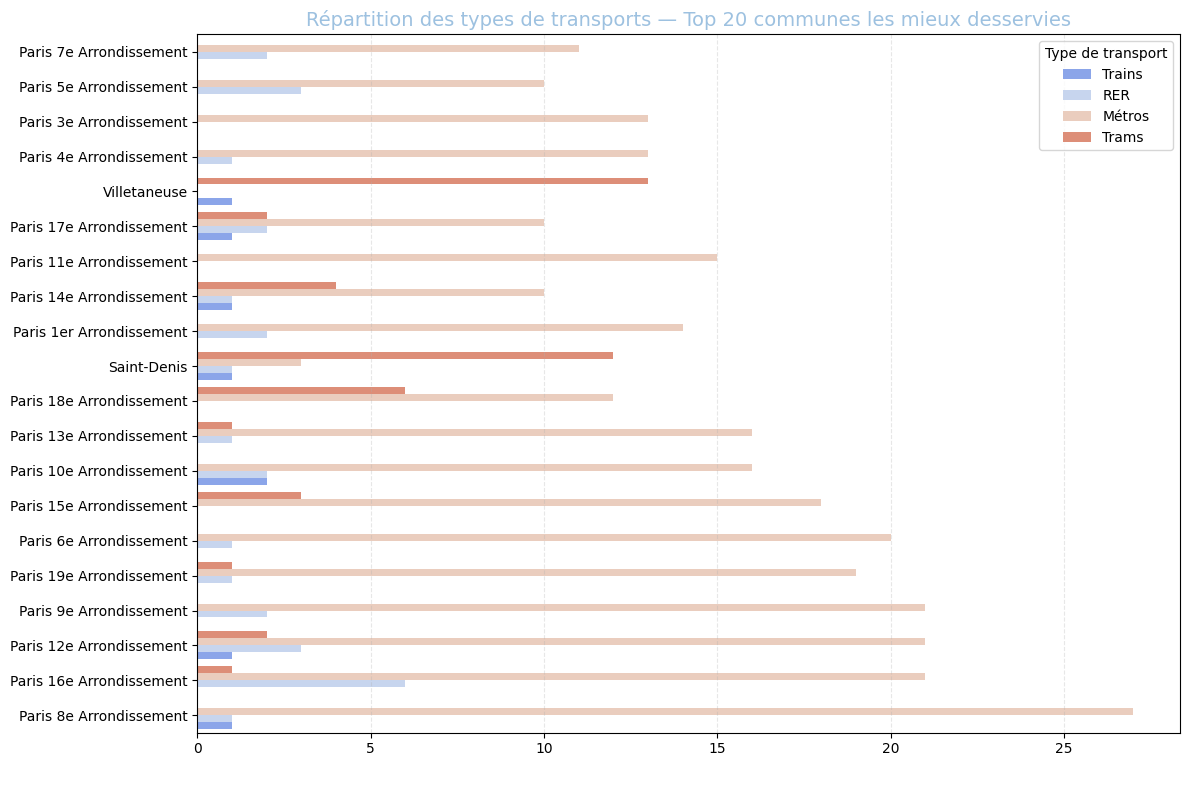

In [5]:
def afficher_top20_transports(dvf_df, transports_gdf):

    # Préparation des communes (positions moyennes) 
    communes_gdf = (
        dvf_df.groupby(["code_commune", "nom_commune", "code_departement"], as_index=False)[["latitude", "longitude"]]
        .mean()
    )
    communes_gdf = gpd.GeoDataFrame(
        communes_gdf,
        geometry=gpd.points_from_xy(communes_gdf["longitude"], communes_gdf["latitude"]),
        crs="EPSG:4326"
    )

    # Harmonisation et association transports - communes les plus proches 
    transports_gdf = transports_gdf.to_crs(epsg=4326)
    communes_m = communes_gdf.to_crs(epsg=2154)
    transports_m = transports_gdf.to_crs(epsg=2154)

    transports_proches = gpd.sjoin_nearest(
        transports_m,
        communes_m[["code_commune", "nom_commune", "code_departement", "geometry"]],
        how="left",
        distance_col="distance_m"
    ).to_crs(epsg=4326)

    # Regroupement par type et commune 
    table_transports = (
        transports_proches.groupby(["code_departement", "code_commune", "nom_commune", "type"])
        .size()
        .unstack(fill_value=0)
        .reset_index()
    )

    # Conversion et total
    for col in table_transports.columns:
        if col not in ["code_departement", "code_commune", "nom_commune"]:
            table_transports[col] = table_transports[col].astype(int)
    table_transports["Total"] = table_transports.drop(columns=["code_departement", "code_commune", "nom_commune"]).sum(axis=1)

    # Fusion
    final_df = communes_gdf.merge(
        table_transports, on=["code_departement", "code_commune", "nom_commune"], how="left"
    ).fillna(0)

    # Calcul du Top 20 
    top20_df = (
        final_df[["nom_commune", "code_departement", "TRAIN", "RER", "METRO", "TRAM", "Total"]]
        .sort_values("Total", ascending=False)
        .head(20)
        .reset_index(drop=True)
    )

    top20_df.columns = ["Commune", "Département", "Trains", "RER", "Métros", "Trams", "Total transports"]

    # Affichage du tableau 
    display(
        top20_df.style.format(precision=0)
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', '#6C8AA5'),
                ('color', 'white'),
                ('font-weight', 'bold'),
                ('text-align', 'center')
            ]},
            {'selector': 'td', 'props': [('text-align', 'center')]}
        ])
        .hide(axis="index")
    )

    # Graphique de répartition 
    top20_melt = top20_df.melt(
        id_vars=["Commune"],
        value_vars=["Trains", "RER", "Métros", "Trams"],
        var_name="Type de transport",
        value_name="Nombre"
    )

    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=top20_melt,
        x="Nombre",
        y="Commune",
        hue="Type de transport",
        palette="coolwarm"
    )

    plt.title("Répartition des types de transports — Top 20 communes les mieux desservies", fontsize=14, color="#9dc1e0")
    plt.xlabel("Nombre de transports", fontsize=12, color="white")
    plt.ylabel("")
    plt.legend(title="Type de transport")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

afficher_top20_transports(dvf_df, transports_gdf)



### Widget 7 : Vérifier la sécurité et l’attractivité du quartier

### 7.1 Comparaison du niveau de sécurité


## Analyse de la sécurité des territoires

Ce module évalue la **sécurité des communes et départements** à partir des données de délinquance.  
L’objectif est d’aider le persona à comprendre **le niveau de sûreté d’un territoire** avant d’y investir ou de s’y installer.

---

###  Méthodologie

Deux indicateurs sont utilisés pour mesurer la sécurité :

- **Nombre total de faits** : c’est la somme de tous les délits recensés dans une commune.  
  Il permet d’avoir une idée du **volume global d’incidents** (ex. : cambriolages, vols, agressions…).

- **Taux pour 1 000 habitants** : il rapporte le nombre de faits à la taille de la population.  
  Cet indicateur permet de **comparer équitablement les territoires**, car une grande ville et une petite commune peuvent avoir des volumes très différents, mais des taux similaires.  
  Exemple : 3 000 faits dans une ville de 100 000 habitants (30‰) est moins inquiétant que 300 faits dans une commune de 5 000 habitants (60‰).

---

###  Interprétation

Les communes sont ensuite classées selon quatre niveaux :
- **Très sûr** : peu de faits et faible taux d’infractions  
- **Sûr** : niveau de délinquance modéré  
- **Moyen** : vigilance conseillée  
- **Risque élevé** : forte concentration d’incidents  

Cette classification permet une **lecture immédiate** du niveau de sécurité d’un territoire.



In [11]:
bpe.columns = bpe.columns.str.strip()
delinq.columns = delinq.columns.str.strip()

def widget_top_securite():
    annees_disponibles = sorted(delinq['annee_donnees'].dropna().unique(), reverse=True) if 'annee_donnees' in delinq.columns else [2023]
    annee_max = annees_disponibles[0]
    
    delinq_init = delinq[delinq['annee_donnees'] == annee_max] if 'annee_donnees' in delinq.columns else delinq
    dept_list = sorted(delinq_init['nom_departement'].dropna().unique())
    
    annee_dropdown = Dropdown(
        options=annees_disponibles,
        value=annee_max,
        description="Année :",
        style={'description_width': 'initial'}
    )
    
    dept_dropdown = Dropdown(
        options=dept_list,
        description="Département :",
        style={'description_width': 'initial'}
    )

    commune_dropdown = Dropdown(
        options=["Toutes les communes"],
        description="Commune :",
        style={'description_width': 'initial'}
    )

    filtre_niveau = Dropdown(
        options=["Tous", "🟢 Très sûr", "🟡 Sûr", "🟠 Moyen", "🔴 Risque élevé"],
        value="Tous",
        description="Filtre sécurité :",
        style={'description_width': 'initial'}
    )

    prev_btn = Button(description="Précédent", button_style='primary')
    next_btn = Button(description="Suivant", button_style='primary')
    top15_btn = Button(description="Top 15 délits", button_style='warning')
    nb_faits_btn = Button(description="Par nombre de faits", button_style='success')
    taux_btn = Button(description="Par taux pour 1000 hab.", button_style='info')

    out = Output()
    page = {'index': 0}
    view_state = {'mode': 'nb_faits', 'display': 'graph'}

    def get_delinq_comm(annee):
        delinq_filtered = delinq[delinq['annee_donnees'] == annee] if 'annee_donnees' in delinq.columns else delinq
        return delinq_filtered.groupby(
            ["departement", "nom_departement", "nom_commune"], as_index=False
        ).agg({
            'nb_faits': 'sum',
            'taux_1000_habitants': 'mean'
        })

    def maj_annee(change=None):
        selected_annee = annee_dropdown.value
        selected_dept_actuel = dept_dropdown.value
        delinq_filtered = delinq[delinq['annee_donnees'] == selected_annee] if 'annee_donnees' in delinq.columns else delinq
        dept_list_updated = sorted(delinq_filtered['nom_departement'].dropna().unique())
        dept_dropdown.options = dept_list_updated
        
        if selected_dept_actuel in dept_list_updated:
            dept_dropdown.value = selected_dept_actuel
        elif dept_list_updated:
            dept_dropdown.value = dept_list_updated[0]
        
        page['index'] = 0
        update_graph()

    def maj_communes(change=None):
        selected_annee = annee_dropdown.value
        selected_dept = dept_dropdown.value
        delinq_filtered = delinq[delinq['annee_donnees'] == selected_annee] if 'annee_donnees' in delinq.columns else delinq
        communes = sorted(delinq_filtered.loc[delinq_filtered["nom_departement"] == selected_dept, "nom_commune"].dropna().unique())
        commune_dropdown.options = ["Toutes les communes"] + communes
        commune_dropdown.value = "Toutes les communes"
        page['index'] = 0
        update_graph()

    def update_graph(change=None):
        if view_state['display'] == 'top15':
            afficher_top15()
            return
            
        out.clear_output()
        with out:
            selected_annee = annee_dropdown.value
            selected_dept = dept_dropdown.value
            selected_commune = commune_dropdown.value
            selected_niveau = filtre_niveau.value
            mode = view_state['mode']

            delinq_comm = get_delinq_comm(selected_annee)
            dept_data = delinq_comm[delinq_comm["nom_departement"] == selected_dept].copy()
            
            if mode == 'nb_faits':
                dept_data["nb_faits"] = dept_data["nb_faits"].fillna(0)
                
                def niveau_securite(nb_faits):
                    if nb_faits < 3000:
                        return "🟢 Très sûr"
                    elif nb_faits < 8000:
                        return "🟡 Sûr"
                    elif nb_faits < 15000:
                        return "🟠 Moyen"
                    else:
                        return "🔴 Risque élevé"
                
                dept_data["Niveau sécurité"] = dept_data["nb_faits"].apply(niveau_securite)
                sort_column = "nb_faits"
                display_column = "nb_faits"
                text_format = '%{text:,.0f} faits'
                axis_title = "Nombre total de faits"
                
            else:  # mode == 'taux'
                dept_data["taux_1000_habitants"] = dept_data["taux_1000_habitants"].fillna(0)
                
                def niveau_securite(taux):
                    if taux < 15:
                        return "🟢 Très sûr"
                    elif taux < 30:
                        return "🟡 Sûr"
                    elif taux < 50:
                        return "🟠 Moyen"
                    else:
                        return "🔴 Risque élevé"
                
                dept_data["Niveau sécurité"] = dept_data["taux_1000_habitants"].apply(niveau_securite)
                sort_column = "taux_1000_habitants"
                display_column = "taux_1000_habitants"
                text_format = '%{text:.1f}‰'
                axis_title = "Taux pour 1000 habitants"

            if selected_niveau != "Tous":
                dept_data = dept_data[dept_data["Niveau sécurité"] == selected_niveau]

            if selected_commune != "Toutes les communes":
                dept_data = dept_data[dept_data["nom_commune"] == selected_commune]

            if dept_data.empty:
                fig = px.bar(title=f"Aucune donnée disponible pour {selected_commune} ({selected_dept}) en {selected_annee}")
                fig.update_layout(
                    annotations=[dict(
                        text="Aucune donnée de criminalité disponible",
                        x=0.5, y=0.5, showarrow=False, font=dict(size=18, color="gray")
                    )],
                    height=400,
                    paper_bgcolor="#fafafa"
                )
                fig.show()
                return

            dept_data = dept_data.sort_values(sort_column, ascending=True).reset_index(drop=True)
            
            total_pages = (len(dept_data) + 19) // 20
            prev_btn.disabled = (page['index'] == 0)
            next_btn.disabled = (page['index'] >= total_pages - 1)
            
            if page['index'] >= total_pages:
                page['index'] = max(0, total_pages - 1)
            
            start = page['index'] * 20
            end = min(start + 20, len(dept_data))
            page_data = dept_data.iloc[start:end].copy()

            page_data["display_value"] = page_data[display_column].apply(
                lambda x: (50 if mode == 'nb_faits' else 0.75) if x == 0 else x
            )

            color_map = {
                "🟢 Très sûr": "#2ECC71",
                "🟡 Sûr": "#F1C40F",
                "🟠 Moyen": "#E67E22",
                "🔴 Risque élevé": "#E74C3C"
            }

            fig = px.bar(
                page_data,
                x="display_value",
                y="nom_commune",
                orientation="h",
                color="Niveau sécurité",
                color_discrete_map=color_map,
                text=display_column,
                hover_data={
                    "nb_faits": True, 
                    "taux_1000_habitants": ":.2f", 
                    "Niveau sécurité": True, 
                    "display_value": False
                },
                title=f"Niveau de sécurité ({selected_dept}) - {selected_commune if selected_commune!='Toutes les communes' else 'Top 20'} - Année {selected_annee}",
            )

            fig.update_traces(
                texttemplate=text_format,
                textposition='outside',
                marker_line_width=1.2,
                marker_line_color='white'
            )
            fig.update_layout(
                yaxis={'categoryorder': 'total ascending'},
                xaxis_title=axis_title,
                height=700,
                plot_bgcolor="#f9f9f9",
                paper_bgcolor="#f9f9f9",
                font=dict(size=12),
                legend_title_text="Niveau de sécurité"
            )
            fig.show()

    def suivant(_):
        page['index'] += 1
        update_graph()

    def precedent(_):
        if page['index'] > 0:
            page['index'] -= 1
            update_graph()

    def afficher_top15(_=None):
        view_state['display'] = 'top15'
        out.clear_output()
        with out:
            selected_annee = annee_dropdown.value
            selected_dept = dept_dropdown.value
            selected_commune = commune_dropdown.value

            delinq_filtered = delinq[delinq['annee_donnees'] == selected_annee] if 'annee_donnees' in delinq.columns else delinq

            if selected_commune != "Toutes les communes":
                data = delinq_filtered[
                    (delinq_filtered["nom_departement"] == selected_dept) &
                    (delinq_filtered["nom_commune"] == selected_commune)
                ]
            else:
                data = delinq_filtered[delinq_filtered["nom_departement"] == selected_dept]

            if data.empty:
                print("Aucune donnée de délinquance disponible.")
                return

            top15 = data.groupby("type_delinquance", as_index=False)["nb_faits"].sum().sort_values("nb_faits", ascending=False).head(15)
            fig = px.bar(
                top15,
                x="nb_faits",
                y="type_delinquance",
                orientation="h",
                text="nb_faits",
                title=f"Top 15 des types de délinquances - {selected_commune if selected_commune!='Toutes les communes' else selected_dept} - Année {selected_annee}",
            )
            fig.update_traces(texttemplate='%{text:,.0f}', textposition='outside', marker_color="#E74C3C")
            fig.update_layout(height=650, paper_bgcolor="#f9f9f9", plot_bgcolor="#f9f9f9")
            fig.show()

    def afficher_nb_faits(_):
        view_state['mode'] = 'nb_faits'
        view_state['display'] = 'graph'
        update_graph()

    def afficher_taux(_):
        view_state['mode'] = 'taux'
        view_state['display'] = 'graph'
        update_graph()

    annee_dropdown.observe(maj_annee, names="value")
    dept_dropdown.observe(maj_communes, names="value")
    commune_dropdown.observe(update_graph, names="value")
    filtre_niveau.observe(update_graph, names="value")
    next_btn.on_click(suivant)
    prev_btn.on_click(precedent)
    top15_btn.on_click(afficher_top15)
    nb_faits_btn.on_click(afficher_nb_faits)
    taux_btn.on_click(afficher_taux)

    controls_top = HBox([annee_dropdown, dept_dropdown, commune_dropdown, filtre_niveau], layout=Layout(justify_content='space-between'))
    nav_buttons = HBox([prev_btn, next_btn], layout=Layout(gap='10px'))
    action_buttons = HBox([top15_btn, nb_faits_btn, taux_btn], layout=Layout(gap='10px'))
    controls_bottom = HBox([nav_buttons, action_buttons], layout=Layout(justify_content='space-between', width='100%'))

    update_graph()
    display(VBox([controls_top, controls_bottom, out]))

widget_top_securite()

### 7.2 Analyse des attractivités par Département

##  Analyse de l’attractivité territoriale par les équipements

Ce module permet d’évaluer l’**attractivité des départements** à travers la répartition et le nombre d’équipements publics et privés (santé, commerce, sport, culture, etc.).  
L’objectif est d’aider là identifier **les zones les mieux dotées** en infrastructures, indicateur clé du confort de vie et du dynamisme local.

---

### Méthodologie

Les données sont regroupées selon trois niveaux :
- **Domaine d’équipement** (ex. : santé, enseignement, commerce)  
- **Sous-domaine** (ex. : soins médicaux, commerces alimentaires)  
- **Type d’équipement** (ex. : hôpital, supermarché, salle de sport)

---

###  Objectif

Cette analyse aide le persona à **comparer le niveau de développement et de services** entre territoires, un facteur déterminant pour **mesurer leur attractivité résidentielle et économique**.


In [12]:
bpe.columns = bpe.columns.str.strip()

def widget_attractivite_departements():
    # ======================================
    # Hiérarchie dynamique
    # ======================================
    domaines_dict = {}
    for domaine in sorted(bpe['domaine_equipement_lib'].dropna().unique()):
        sous_doms = sorted(
            bpe.loc[bpe['domaine_equipement_lib'] == domaine, 'sous_domaine_equipement_lib']
            .dropna().unique()
        )
        domaines_dict[domaine] = {}
        for sous_dom in sous_doms:
            types = sorted(
                bpe.loc[
                    (bpe['domaine_equipement_lib'] == domaine)
                    & (bpe['sous_domaine_equipement_lib'] == sous_dom),
                    'type_equipement_lib'
                ].dropna().unique()
            )
            domaines_dict[domaine][sous_dom] = types

    # ======================================
    # Filtres et boutons
    # ======================================
    domaine_dropdown = widgets.Dropdown(
        options=['Tous'] + list(domaines_dict.keys()),
        description="Domaine :",
        value='Tous'
    )
    sous_domaine_dropdown = widgets.Dropdown(
        options=['Tous'],
        description="Sous-domaine :",
        value='Tous'
    )
    type_dropdown = widgets.Dropdown(
        options=['Tous'],
        description="Type :",
        value='Tous'
    )

    bouton_compare = widgets.Button(
        description="Comparer les départements",
        button_style='primary'
    )
    bouton_details = widgets.Button(
        description="Afficher les détails",
        button_style='success'
    )
    
    out = widgets.Output()
    current_view = {'mode': 'compare'}  # par défaut : vue comparatif

    # ======================================
    # Mise à jour hiérarchique des filtres
    # ======================================
    def update_sous_domaines(change):
        dom = domaine_dropdown.value
        if dom == 'Tous':
            sous_domaine_dropdown.options = ['Tous']
            type_dropdown.options = ['Tous']
        else:
            sous_domaine_dropdown.options = ['Tous'] + list(domaines_dict[dom].keys())
        sous_domaine_dropdown.value = 'Tous'
        update_types(None)

    def update_types(change):
        dom = domaine_dropdown.value
        sous_dom = sous_domaine_dropdown.value
        if dom != 'Tous' and sous_dom != 'Tous':
            type_dropdown.options = ['Tous'] + list(domaines_dict[dom][sous_dom])
        elif dom != 'Tous':
            all_types = sorted(
                bpe[bpe['domaine_equipement_lib'] == dom]['type_equipement_lib']
                .dropna().unique()
            )
            type_dropdown.options = ['Tous'] + all_types
        else:
            type_dropdown.options = ['Tous']
        type_dropdown.value = 'Tous'

    domaine_dropdown.observe(update_sous_domaines, names='value')
    sous_domaine_dropdown.observe(update_types, names='value')

    # ======================================
    # Fonctions principales
    # ======================================
    def get_filtered_data():
        df = bpe.copy()
        dom, sous_dom, typ = domaine_dropdown.value, sous_domaine_dropdown.value, type_dropdown.value

        if dom != 'Tous':
            df = df[df['domaine_equipement_lib'] == dom]
        if sous_dom != 'Tous':
            df = df[df['sous_domaine_equipement_lib'] == sous_dom]
        if typ != 'Tous':
            df = df[df['type_equipement_lib'] == typ]
        return df

    def vue_comparaison():
        df = get_filtered_data()
        with out:
            clear_output(wait=True)
            if df.empty:
                print("Aucune donnée pour ce filtre.")
                return

            df_agg = (
                df.groupby('nom_departement')['nombre_equipements']
                .sum().reset_index()
            )
            df_agg = df_agg[df_agg['nombre_equipements'] > 0]
            df_agg = df_agg.sort_values('nombre_equipements', ascending=False)

            fig = go.Figure(data=[
                go.Bar(
                    x=df_agg['nombre_equipements'],
                    y=df_agg['nom_departement'],
                    orientation='h',
                    marker_color='#2a9df4',
                    text=df_agg['nombre_equipements'],
                    textposition='outside'
                )
            ])

            titre = "Classement des départements selon le nombre d’équipements"
            dom, sous_dom, typ = domaine_dropdown.value, sous_domaine_dropdown.value, type_dropdown.value
            if dom != 'Tous':
                titre += f" – {dom}"
            if sous_dom != 'Tous':
                titre += f" / {sous_dom}"
            if typ != 'Tous':
                titre += f" / {typ}"

            fig.update_layout(
                title=titre,
                xaxis_title="Nombre d’équipements",
                yaxis_title="Département",
                height=max(600, len(df_agg) * 25),
                paper_bgcolor="#f9f9f9",
                font=dict(size=11)
            )
            fig.show()

            top = df_agg.iloc[0]
            total_nat = df['nombre_equipements'].sum()
            print(f"Département le plus équipé : {top['nom_departement']} ({int(top['nombre_equipements'])} équipements, {round(100*top['nombre_equipements']/total_nat, 1)} % du total national)")

    def vue_details():
        df = get_filtered_data()
        with out:
            clear_output(wait=True)
            if df.empty:
                print("Aucun équipement à afficher pour ce filtre.")
                return

            df_detail = (
                df.groupby(['nom_departement', 'type_equipement_lib'])['nombre_equipements']
                .sum().reset_index()
                .sort_values(['nom_departement', 'nombre_equipements'], ascending=[True, False])
            )
            df_detail = df_detail[df_detail['nombre_equipements'] > 0]
            display(df_detail.style.format({"nombre_equipements": "{:,.0f}"}))

    # ======================================
    # Réactivité dynamique
    # ======================================
    def update_view(change=None):
        if current_view['mode'] == 'compare':
            vue_comparaison()
        else:
            vue_details()

    domaine_dropdown.observe(update_view, names='value')
    sous_domaine_dropdown.observe(update_view, names='value')
    type_dropdown.observe(update_view, names='value')

    # ======================================
    # Boutons d’action
    # ======================================
    def set_compare(_):
        current_view['mode'] = 'compare'
        vue_comparaison()

    def set_details(_):
        current_view['mode'] = 'details'
        vue_details()

    bouton_compare.on_click(set_compare)
    bouton_details.on_click(set_details)

    # ======================================
    # Layout final
    # ======================================
    filtres_box = widgets.VBox([
        widgets.HBox([domaine_dropdown, sous_domaine_dropdown]),
        widgets.HBox([type_dropdown])
    ])
    boutons_box = widgets.HBox([bouton_compare, bouton_details])

    display(widgets.VBox([filtres_box, boutons_box, out]))
    vue_comparaison()

# === Exécution ===
widget_attractivite_departements()


### 7.3 Analyse de l'attractivité des communes dans chaque département

In [13]:
bpe.columns = bpe.columns.str.strip()

def widget_attractivite_commune():
    # ==========================================
    # Hiérarchie dynamique
    # ==========================================
    domaines_dict = {}
    for domaine in sorted(bpe['domaine_equipement_lib'].dropna().unique()):
        sous_doms = sorted(bpe.loc[bpe['domaine_equipement_lib'] == domaine, 'sous_domaine_equipement_lib'].dropna().unique())
        domaines_dict[domaine] = {}
        for sous_dom in sous_doms:
            types = sorted(bpe.loc[(bpe['domaine_equipement_lib'] == domaine) & (bpe['sous_domaine_equipement_lib'] == sous_dom), 'type_equipement_lib'].dropna().unique())
            domaines_dict[domaine][sous_dom] = types

    # ==========================================
    # Filtres interactifs
    # ==========================================
    dept_list = sorted(bpe["nom_departement"].dropna().unique())
    dept_dropdown = widgets.Dropdown(options=dept_list, description="Département :", value=dept_list[0], style={'description_width': 'initial'})
    commune_dropdown = widgets.Dropdown(description="Commune :", style={'description_width': 'initial'})
    domaine_dropdown = widgets.Dropdown(options=['Tous'] + list(domaines_dict.keys()), description="Domaine :", value='Tous', style={'description_width': 'initial'})
    sous_domaine_dropdown = widgets.Dropdown(options=['Tous'], description="Sous-domaine :", value='Tous', style={'description_width': 'initial'})
    type_dropdown = widgets.Dropdown(options=['Tous'], description="Type d'équipement :", value='Tous', style={'description_width': 'initial'})

    out = widgets.Output()

    # ==========================================
    #  Mise à jour des filtres hiérarchiques
    # ==========================================
    def update_communes(change):
        dept = dept_dropdown.value
        communes = sorted(bpe[bpe["nom_departement"] == dept]["nom_commune"].dropna().unique())
        commune_dropdown.options = communes
        commune_dropdown.value = communes[0] if communes else None

    def update_sous_domaines(change):
        dom = domaine_dropdown.value
        if dom == 'Tous':
            sous_domaine_dropdown.options = ['Tous']
            type_dropdown.options = ['Tous']
        else:
            sous_domaine_dropdown.options = ['Tous'] + list(domaines_dict[dom].keys())
        sous_domaine_dropdown.value = 'Tous'
        type_dropdown.value = 'Tous'
        update_types(None)

    def update_types(change):
        dom = domaine_dropdown.value
        sous_dom = sous_domaine_dropdown.value
        if dom != 'Tous' and sous_dom != 'Tous':
            type_dropdown.options = ['Tous'] + list(domaines_dict[dom][sous_dom])
        elif dom != 'Tous':
            all_types = sorted(bpe[bpe['domaine_equipement_lib'] == dom]['type_equipement_lib'].dropna().unique())
            type_dropdown.options = ['Tous'] + all_types
        else:
            type_dropdown.options = ['Tous']
        type_dropdown.value = 'Tous'
        update_details(None)

    dept_dropdown.observe(update_communes, names='value')
    update_communes(None)

    # ==========================================
    #  Fonction d'affichage principale
    # ==========================================
    def update_details(change=None):
        with out:
            clear_output(wait=True)

            commune = commune_dropdown.value
            dept = dept_dropdown.value
            dom = domaine_dropdown.value
            sous_dom = sous_domaine_dropdown.value
            typ = type_dropdown.value

            if not commune or not dept:
                print("Aucune commune sélectionnée.")
                return

            # --- Filtrage des données selon les sélections ---
            bpe_commune = bpe[(bpe["nom_departement"] == dept) & (bpe["nom_commune"] == commune)]

            if dom != 'Tous':
                bpe_commune = bpe_commune[bpe_commune['domaine_equipement_lib'] == dom]
            if sous_dom != 'Tous':
                bpe_commune = bpe_commune[bpe_commune['sous_domaine_equipement_lib'] == sous_dom]
            if typ != 'Tous':
                bpe_commune = bpe_commune[bpe_commune['type_equipement_lib'] == typ]

            if bpe_commune.empty:
                print("Aucun équipement correspondant à la sélection.")
                return

            # ===================================================
            # 1️⃣ PIE CHART - Répartition par DOMAINE
            # ===================================================
            df_pie = bpe_commune.groupby('domaine_equipement_lib')['nombre_equipements'].sum().reset_index()
            df_pie = df_pie[df_pie['nombre_equipements'] > 0].sort_values('nombre_equipements', ascending=False)

            fig_pie = go.Figure(data=[go.Pie(
                labels=df_pie['domaine_equipement_lib'],
                values=df_pie['nombre_equipements'],
                hole=0.3,
                textinfo='percent',
                hovertemplate='<b>%{label}</b><br>Équipements: %{value}<extra></extra>'
            )])
            fig_pie.update_layout(
                title="Répartition par Domaine",
                height=500,
                paper_bgcolor="#f9f9f9",
                margin=dict(l=20, r=20, t=50, b=20)
            )

            # ===================================================
            # 2️⃣ BAR CHART - Répartition par SOUS-DOMAINE
            # ===================================================
            df_bar = bpe_commune.groupby('sous_domaine_equipement_lib')['nombre_equipements'].sum().reset_index()
            df_bar = df_bar[df_bar['nombre_equipements'] > 0].sort_values('nombre_equipements', ascending=True)

            fig_bar = go.Figure(data=[go.Bar(
                y=df_bar['sous_domaine_equipement_lib'],
                x=df_bar['nombre_equipements'],
                orientation='h',
                marker=dict(color=df_bar['nombre_equipements'], colorscale='Blues', showscale=False),
                hovertemplate='<b>%{y}</b><br>Équipements: %{x}<extra></extra>'
            )])
            fig_bar.update_layout(
                title="Répartition par Sous-Domaine",
                height=500,
                paper_bgcolor="#f9f9f9",
                plot_bgcolor="#f9f9f9",
                xaxis_title="Nombre d'équipements",
                margin=dict(l=200, r=20, t=50, b=20),
                showlegend=False
            )

            # Afficher les deux graphes côte à côte avec des Output widgets
            out_pie = widgets.Output()
            out_bar = widgets.Output()
            
            with out_pie:
                fig_pie.show()
            with out_bar:
                fig_bar.show()
            
            # Afficher côte à côte
            display(widgets.HBox([out_pie, out_bar]))

            # ===================================================
            # 3️⃣ TABLEAU - Détail des équipements
            # ===================================================
            df_table = bpe_commune[['domaine_equipement_lib', 'sous_domaine_equipement_lib', 'type_equipement_lib', 'nombre_equipements']].copy()
            df_table = df_table[df_table['nombre_equipements'] > 0].sort_values('nombre_equipements', ascending=False)

            # Créer le tableau Plotly
            fig_table = go.Figure(data=[go.Table(
                header=dict(
                    values=[
                        '<b>Domaine</b>',
                        '<b>Sous-Domaine</b>',
                        '<b>Type d\'Équipement</b>',
                        '<b>Nombre</b>'
                    ],
                    fill_color='#34495e',
                    align='left',
                    font=dict(color='white', size=12),
                    height=30
                ),
                cells=dict(
                    values=[
                        df_table['domaine_equipement_lib'],
                        df_table['sous_domaine_equipement_lib'],
                        df_table['type_equipement_lib'],
                        df_table['nombre_equipements']
                    ],
                    fill_color='#ecf0f1',
                    align='left',
                    font=dict(size=11),
                    height=25
                )
            )])

            fig_table.update_layout(
                title=f"Détail des Équipements – {commune}",
                height=max(400, len(df_table) * 25 + 100),
                paper_bgcolor="#f9f9f9",
                margin=dict(l=20, r=20, t=50, b=20)
            )

            # Afficher le tableau
            display(HTML("<hr style='margin-top: 30px; margin-bottom: 30px;'>"))
            fig_table.show()

            # Résumé statistique
            total_equipements = bpe_commune['nombre_equipements'].sum()
            nb_domaines = bpe_commune['domaine_equipement_lib'].nunique()
            nb_sous_domaines = bpe_commune['sous_domaine_equipement_lib'].nunique()
            nb_types = bpe_commune['type_equipement_lib'].nunique()

            display(HTML(f"""
            <div style='background-color: #ecf0f1; padding: 20px; border-radius: 8px; margin-top: 20px; text-align: center;'>
                <h3 style='color: #2c3e50; margin: 0;'>📊 Résumé</h3>
                <div style='display: grid; grid-template-columns: 1fr 1fr 1fr 1fr; gap: 20px; margin-top: 15px;'>
                    <div><strong style='font-size: 18px; color: #3498db;'>{int(total_equipements)}</strong><br>Équipements</div>
                    <div><strong style='font-size: 18px; color: #e74c3c;'>{nb_domaines}</strong><br>Domaines</div>
                    <div><strong style='font-size: 18px; color: #27ae60;'>{nb_sous_domaines}</strong><br>Sous-Domaines</div>
                    <div><strong style='font-size: 18px; color: #f39c12;'>{nb_types}</strong><br>Types</div>
                </div>
            </div>
            """))

    # ==========================================
    #  Observers et Layout
    # ==========================================
    commune_dropdown.observe(update_details, names='value')
    domaine_dropdown.observe(update_sous_domaines, names='value')
    sous_domaine_dropdown.observe(update_types, names='value')
    type_dropdown.observe(update_details, names='value')

    # Layout
    filtres_box = widgets.VBox([
        widgets.HBox([dept_dropdown, commune_dropdown]),
        widgets.HBox([domaine_dropdown, sous_domaine_dropdown, type_dropdown])
    ], layout=widgets.Layout(border='1px solid #ddd', padding='15px', border_radius='5px'))

    display(widgets.VBox([
        widgets.HTML("<h2 style='text-align: center; color: #2c3e50; margin-bottom: 20px;'>📍 Analyse Attractivité Commune</h2>"),
        filtres_box,
        widgets.HTML("<hr style='margin: 20px 0;'>"),
        out
    ]))
    
    update_details()

# === Exécution ===
widget_attractivite_commune()

### Widget 8: Trouver des biens accessibles avec son budget (par commune)

In [10]:
def afficher_widget_budget(dvf_df, communes_gdf):
  
    # Préparation des données 
    dvf_df["valeur_fonciere"] = pd.to_numeric(dvf_df["valeur_fonciere"], errors="coerce")
    dvf_df["code_commune"] = dvf_df["code_commune"].astype(str)
    communes_gdf["INSEE_COM"] = communes_gdf["INSEE_COM"].astype(str)

    moyennes_df = (
        dvf_df.groupby(["code_commune", "nom_commune"], as_index=False)["valeur_fonciere"]
        .mean()
        .rename(columns={"valeur_fonciere": "valeur_fonciere_moyenne"})
    )

    # Fusion sur les codes INSEE
    communes_valeurs = communes_gdf.merge(
        moyennes_df, left_on="INSEE_COM", right_on="code_commune", how="inner"
    )

    min_val = communes_valeurs["valeur_fonciere_moyenne"].min()
    max_val = communes_valeurs["valeur_fonciere_moyenne"].max()
    colormap = cm.linear.YlOrRd_09.scale(min_val, max_val)
    colormap.caption = "Valeur foncière moyenne (€)"

    # Fonction d’affichage de la carte 
    def afficher_carte_range(budget_range):
        budget_min, budget_max = budget_range
        clear_output(wait=True)

        communes_filtrees = communes_valeurs[
            (communes_valeurs["valeur_fonciere_moyenne"] >= budget_min)
            & (communes_valeurs["valeur_fonciere_moyenne"] <= budget_max)
        ]

        m = folium.Map(location=[48.8566, 2.3522], zoom_start=9, tiles="CartoDB positron")
        cluster = MarkerCluster(name=f"Entre {budget_min:,.0f} € et {budget_max:,.0f} €").add_to(m)

        for _, row in communes_filtrees.iterrows():
            valeur = row["valeur_fonciere_moyenne"]
            commune = row["nom_commune"]
            coords = (row.geometry.y, row.geometry.x)
            color = colormap(valeur)

            popup = f"""
            <div style='font-family: Arial; font-size: 13px; line-height: 1.5;
                        border-radius: 10px; padding: 10px 15px;
                        background-color: rgba(255,255,255,0.95);
                        box-shadow: 0 2px 8px rgba(0,0,0,0.2);
                        text-align: center;'>
                <h4 style='margin:0; color:{color}; font-size:15px;'>🏙️ <b>{commune}</b></h4>
                <hr style='border:none; border-top:1px solid #ddd; margin:6px 0;'>
                <p style='margin:3px 0;'>
                    💰 <b>Valeur foncière moyenne :</b><br>
                    <span style='color:{color}; font-weight:bold; font-size:14px;'>{valeur:,.0f} €</span>
                </p>
            </div>
            """
            folium.CircleMarker(
                location=coords,
                radius=5,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.8,
                popup=popup
            ).add_to(cluster)

        colormap.add_to(m)
        display(m)

    # Slider interactif 
    range_slider = widgets.IntRangeSlider(
        value=(int(min_val), int(max_val/2)),
        min=int(min_val),
        max=int(max_val),
        step=50000,
        description='📊 Budget (min - max)',
        continuous_update=False,
        layout=widgets.Layout(width="75%"),
        style={'description_width': 'initial'}
    )

    out = widgets.interactive_output(afficher_carte_range, {'budget_range': range_slider})

    # Style et affichage 
    style_html = """
    <style>
    .output_subarea {
        color: #FFFFFF !important;
        font-family: 'Segoe UI', sans-serif;
        font-size: 14px;
    }
    .widget-inline-hbox {
        background-color: #6C8AA5 !important;
        border-radius: 12px;
        padding: 10px 20px;
        box-shadow: 0 2px 6px rgba(0,0,0,0.6);
    }
    </style>
    """

    display(HTML(style_html))
    display(range_slider, out)


afficher_widget_budget(dvf_df, communes_gdf)




NameError: name 'communes_gdf' is not defined

### TOP 20 des communes selon le budget

In [ ]:


def afficher_widget_top20(dvf_df,communes_gdf):

    # Préparation des données
    dvf_df["valeur_fonciere"] = pd.to_numeric(dvf_df["valeur_fonciere"], errors="coerce")
    dvf_df["code_commune"] = dvf_df["code_commune"].astype(str)
    communes_gdf["INSEE_COM"] = communes_gdf["INSEE_COM"].astype(str)

    moyennes_df = (
        dvf_df.groupby(["code_commune", "nom_commune"], as_index=False)["valeur_fonciere"]
        .mean()
        .rename(columns={"valeur_fonciere": "valeur_fonciere_moyenne"})
    )

    communes_valeurs = communes_gdf.merge(
        moyennes_df, left_on="INSEE_COM", right_on="code_commune", how="inner"
    )

    output_top20 = widgets.Output()

    # les bornes 
    budget_min_widget = widgets.BoundedIntText(
        value=int(communes_valeurs["valeur_fonciere_moyenne"].min()),
        min=0,
        max=int(communes_valeurs["valeur_fonciere_moyenne"].max()),
        step=50000,
        description=' Budget min :',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width="250px")
    )

    budget_max_widget = widgets.BoundedIntText(
        value=int(communes_valeurs["valeur_fonciere_moyenne"].max() / 2),
        min=0,
        max=int(communes_valeurs["valeur_fonciere_moyenne"].max()),
        step=50000,
        description=' Budget max :',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width="250px")
    )

    # Fonction de mise à jour du Top 20 
    def afficher_top20_v2(budget_min, budget_max):
        communes_filtrees = communes_valeurs[
            (communes_valeurs["valeur_fonciere_moyenne"] >= budget_min)
            & (communes_valeurs["valeur_fonciere_moyenne"] <= budget_max)
        ]

        top20 = communes_filtrees.sort_values("valeur_fonciere_moyenne", ascending=True).head(20)

        output_top20.clear_output()
        with output_top20:
            if top20.empty:
                display(HTML(f"""
                <p style='color:#ff6b6b; font-family:Segoe UI;'>
                    Aucune commune ne correspond à cette plage.
                </p>
                """))
            else:
                display(HTML(f"""
                <h3 style='color:#9dc1e0; font-family:Segoe UI; margin-bottom:10px;'>
                     Top 20 des communes pour un budget entre {budget_min:,.0f} € et {budget_max:,.0f} €
                </h3>
                """))
                display(
                    top20[["nom_commune", "valeur_fonciere_moyenne"]]
                    .rename(columns={
                        "nom_commune": "Commune",
                        "valeur_fonciere_moyenne": "Valeur foncière moyenne (€)"
                    })
                    .style.format({"Valeur foncière moyenne (€)": "{:,.0f} €"})
                    .set_table_styles([
                        {'selector': 'th', 'props': [
                            ('background-color', '#6C8AA5'),
                            ('color', 'white'),
                            ('font-weight', 'bold'),
                            ('text-align', 'center')
                        ]},
                        {'selector': 'td', 'props': [('text-align', 'center')]}
                    ])
                    .hide(axis="index")
                )

    # Liaison interactive 
    widgets.interactive_output(
        afficher_top20_v2,
        {'budget_min': budget_min_widget, 'budget_max': budget_max_widget}
    )

    # Conteneur des widgets
    box_budgets = widgets.HBox([budget_min_widget, budget_max_widget])
    box_budgets.add_class("budget-box")

    display(box_budgets)
    display(output_top20)

    # Style visuel 
    display(HTML("""
    <style>
    .budget-box {
        display: flex !important;
        justify-content: center !important;
        align-items: center !important;
        background: rgba(108, 138, 165, 0.3);
        border-radius: 12px;
        padding: 10px 20px;
        gap: 20px;
        box-shadow: 0 3px 8px rgba(0,0,0,0.3);
        margin-bottom: 15px;
    }
    .output_subarea {
        color: white !important;
        font-family: Segoe UI, sans-serif !important;
    }
    table.dataframe, th, td {
        border: 1px solid #444 !important;
    }
    </style>
    """))

afficher_widget_top20(dvf_df, communes_gdf)

Output()

### Widget 9 : Obtenir un classement des Top 10 opportunités actuelles (un tableau ou score automatique)

In [ ]:
def calculate_coloc_advantage(df_rendement):
    """
    Calculate colocation advantage for each commune by comparing yields between property types
    
    The idea: In some communes, renting large properties (T3+, Maison) as coloc 
    can be more profitable than renting small units (T1-T2)
    """
    
    # Get average metrics by commune (not by type)
    commune_avg = df_rendement.groupby(['code_commune', 'nom_commune']).agg({
        'loyer_predit_m2': 'mean',
        'prix_m2': 'mean'
    }).reset_index()
    
    # Get metrics by commune and type
    commune_types = df_rendement.groupby(['code_commune', 'nom_commune', 'type_local']).agg({
        'rendement_brut': 'mean',
        'prix_m2': 'mean',
        'loyer_predit_m2': 'mean'
    }).reset_index()
    
    # For each property type in each commune, calculate coloc advantage
    result = []
    
    for commune in commune_types['code_commune'].unique():
        commune_data = commune_types[commune_types['code_commune'] == commune]
        commune_name = commune_data['nom_commune'].iloc[0]
        
        # Get T1-T2 loyer if exists
        t1_t2_data = commune_data[commune_data['type_local'] == 'Appartement T1-T2']
        t1_t2_loyer = t1_t2_data['loyer_predit_m2'].iloc[0] if len(t1_t2_data) > 0 else None
        
        # Calculate advantage for each type
        for _, row in commune_data.iterrows():
            type_local = row['type_local']
            
            if type_local in ['Appartement T3+', 'Maison'] and t1_t2_loyer is not None:
                # Large property can benefit from coloc if T1-T2 loyer is higher
                loyer_diff = t1_t2_loyer - row['loyer_predit_m2']
                advantage = max(0, loyer_diff * 10)  # Scale up
            else:
                advantage = 0
            
            result.append({
                'code_commune': commune,
                'nom_commune': commune_name,
                'type_local': type_local,
                'coloc_advantage_raw': advantage
            })
    
    result_df = pd.DataFrame(result)
    
    # Normalize to 0-100 scale
    if result_df['coloc_advantage_raw'].max() > 0:
        result_df['coloc_advantage_score'] = (
            result_df['coloc_advantage_raw'] / result_df['coloc_advantage_raw'].max() * 100
        )
    else:
        result_df['coloc_advantage_score'] = 0
    
    return result_df[['code_commune', 'nom_commune', 'type_local', 'coloc_advantage_score']]


def calculate_master_opportunity_score(df_rendement, df_liquidite=None, df_transport=None, 
                                       df_services=None, df_security=None,
                                       max_budget=None, weights=None, verbose=True):
    """
    Calculate comprehensive investment opportunity score
    
    Parameters:
    -----------
    df_rendement : DataFrame
        DataFrame with rendement_brut, prix_m2, nombre_mutations, etc. (REQUIRED)
    df_liquidite : DataFrame, optional
        DataFrame with score_liquidite_2024 (0-100). If None, liquidité not included.
    df_transport : DataFrame, optional
        DataFrame with transport_count or transport_score per commune
    df_services : DataFrame, optional
        DataFrame with services_count or services_score per commune
    df_security : DataFrame, optional
        DataFrame with security_score per commune
    max_budget : float, optional
        Maximum budget in euros
    weights : dict, optional
        Custom weights for each factor. Only factors with data will be used.
    verbose : bool, optional
        If True, print detailed logging of score calculation
    
    Returns:
    --------
    DataFrame with opportunity scores and rankings
    """
    
    if verbose:
        print("\n" + "="*80)
        print("🎯 CALCUL DU SCORE D'OPPORTUNITÉ D'INVESTISSEMENT")
        print("="*80 + "\n")
    
    # Determine available factors
    available_factors = ['rendement', 'coloc', 'budget']  # Always available from df_rendement
    
    if df_liquidite is not None:
        available_factors.append('liquidite')
    if df_transport is not None:
        available_factors.append('transport')
    if df_services is not None:
        available_factors.append('services')
    if df_security is not None:
        available_factors.append('security')
    
    if verbose:
        print(f"📊 Facteurs disponibles: {', '.join(available_factors)}")
        print(f"   Total: {len(available_factors)} facteurs\n")
    
    # Default weights based on available factors
    if weights is None:
        n_factors = len(available_factors)
        
        if n_factors == 3:  # Only rendement, coloc, budget
            weights = {
                'rendement': 0.60,
                'coloc': 0.25,
                'budget': 0.15
            }
        elif n_factors == 4:  # + liquidite
            weights = {
                'rendement': 0.40,
                'liquidite': 0.35,
                'coloc': 0.15,
                'budget': 0.10
            }
        elif n_factors == 5:  # + transport or services
            weights = {
                'rendement': 0.35,
                'liquidite': 0.30 if 'liquidite' in available_factors else 0,
                'coloc': 0.15,
                'budget': 0.10,
                'transport': 0.10 if 'transport' in available_factors else 0,
                'services': 0.10 if 'services' in available_factors else 0
            }
        elif n_factors == 6:
            weights = {
                'rendement': 0.30,
                'liquidite': 0.25 if 'liquidite' in available_factors else 0,
                'coloc': 0.15,
                'budget': 0.10,
                'transport': 0.10 if 'transport' in available_factors else 0,
                'services': 0.10 if 'services' in available_factors else 0,
                'security': 0.10 if 'security' in available_factors else 0
            }
        else:  # All factors (7)
            weights = {
                'rendement': 0.25,
                'liquidite': 0.25,
                'coloc': 0.15,
                'budget': 0.10,
                'transport': 0.10,
                'services': 0.10,
                'security': 0.05
            }
    
    # --- START WITH RENDEMENT DATA ---
    df_score = df_rendement.copy()
    
    if verbose:
        print(f"📈 Données de départ: {len(df_score)} lignes (commune × type de bien)")
        print(f"   Communes uniques: {df_score['code_commune'].nunique()}")
        print(f"   Types de biens: {df_score['type_local'].unique().tolist()}\n")
    
    # --- 1. NORMALIZE RENDEMENT TO 0-100 ---
    if verbose:
        print("1️⃣  Normalisation du rendement brut...")
    
    rend_min = df_score['rendement_brut'].min()
    rend_max = df_score['rendement_brut'].max()
    df_score['score_rendement'] = ((df_score['rendement_brut'] - rend_min) / 
                                    (rend_max - rend_min) * 100)
    
    if verbose:
        print(f"   Range: {rend_min:.2f}% → {rend_max:.2f}%")
        print(f"   Score moyen: {df_score['score_rendement'].mean():.1f}/100\n")
    
    # --- 2. MERGE LIQUIDITÉ (if available) ---
    if df_liquidite is not None:
        if verbose:
            print("2️⃣  Fusion des scores de liquidité...")
        
        df_score = df_score.merge(
            df_liquidite[['code_commune', 'score_liquidite_2024']], 
            on='code_commune', 
            how='left'
        )
        df_score['score_liquidite'] = df_score['score_liquidite_2024'].fillna(0)
        
        if verbose:
            matched = (df_score['score_liquidite'] > 0).sum()
            print(f"   Communes avec données de liquidité: {matched}/{len(df_score)}")
            print(f"   Score moyen: {df_score['score_liquidite'].mean():.1f}/100\n")
    else:
        df_score['score_liquidite'] = 0
        weights['liquidite'] = 0
        if verbose:
            print("2️⃣  Liquidité: Pas de données disponibles (score = 0)\n")
    
    # --- 3. CALCULATE COLOC ADVANTAGE ---
    if verbose:
        print("3️⃣  Calcul du potentiel colocation...")
    
    coloc_scores = calculate_coloc_advantage(df_rendement)
    df_score = df_score.merge(
        coloc_scores[['code_commune', 'type_local', 'coloc_advantage_score']], 
        on=['code_commune', 'type_local'], 
        how='left'
    )
    df_score['score_coloc'] = df_score['coloc_advantage_score'].fillna(0)
    
    if verbose:
        has_coloc = (df_score['score_coloc'] > 0).sum()
        print(f"   Propriétés avec potentiel coloc: {has_coloc}/{len(df_score)}")
        print(f"   Score moyen: {df_score['score_coloc'].mean():.1f}/100\n")
    
    # --- 4. BUDGET ACCESSIBILITY SCORE ---
    if verbose:
        print("4️⃣  Calcul de l'accessibilité budgétaire...")
    
    if max_budget is not None:
        # Estimate property price
        df_score['estimated_price'] = df_score.apply(
            lambda row: row['prix_m2'] * (80 if row['type_local'] == 'Maison' else 50),
            axis=1
        )
        
        # Score: 100 if within budget, decreasing as price increases
        df_score['score_budget'] = np.where(
            df_score['estimated_price'] <= max_budget,
            100,
            np.maximum(0, 100 - ((df_score['estimated_price'] - max_budget) / max_budget * 100))
        )
        
        df_score['within_budget'] = df_score['estimated_price'] <= max_budget
        
        if verbose:
            within = df_score['within_budget'].sum()
            print(f"   Budget maximum: {max_budget:,.0f} €")
            print(f"   Biens dans le budget: {within}/{len(df_score)}")
            print(f"   Score moyen: {df_score['score_budget'].mean():.1f}/100\n")
    else:
        # Use inverse price normalization
        price_min = df_score['prix_m2'].min()
        price_max = df_score['prix_m2'].max()
        df_score['score_budget'] = ((price_max - df_score['prix_m2']) / 
                                     (price_max - price_min) * 100)
        df_score['within_budget'] = True
        
        if verbose:
            print(f"   Pas de budget spécifié - normalisation par prix")
            print(f"   Range prix/m²: {price_min:.0f}€ → {price_max:.0f}€")
            print(f"   Score moyen: {df_score['score_budget'].mean():.1f}/100\n")
    
    # --- 5. TRANSPORT SCORE (if available) ---
    if df_transport is not None:
        if verbose:
            print("5️⃣  Fusion des données de transport...")
        
        df_score = df_score.merge(
            df_transport[['code_commune', 'transport_score' if 'transport_score' in df_transport.columns else 'transport_count']], 
            on='code_commune', 
            how='left'
        )
        
        if 'transport_count' in df_score.columns and 'transport_score' not in df_score.columns:
            trans_min = df_score['transport_count'].min()
            trans_max = df_score['transport_count'].max()
            if trans_max > trans_min:
                df_score['score_transport'] = ((df_score['transport_count'] - trans_min) / 
                                                (trans_max - trans_min) * 100)
            else:
                df_score['score_transport'] = 50
            
            if verbose:
                print(f"   Normalisation du nombre de transports ({trans_min:.0f} → {trans_max:.0f})")
        else:
            df_score['score_transport'] = df_score.get('transport_score', 0)
        
        df_score['score_transport'] = df_score['score_transport'].fillna(0)
        
        if verbose:
            print(f"   Score moyen: {df_score['score_transport'].mean():.1f}/100\n")
    else:
        df_score['score_transport'] = 0
        weights['transport'] = 0
        if verbose:
            print("5️⃣  Transport: Pas de données disponibles (score = 0)\n")
    
    # --- 6. SERVICES SCORE (if available) ---
    if df_services is not None:
        if verbose:
            print("6️⃣  Fusion des données de services...")
        
        df_score = df_score.merge(
            df_services[['code_commune', 'services_score' if 'services_score' in df_services.columns else 'services_count']], 
            on='code_commune', 
            how='left'
        )
        
        if 'services_count' in df_score.columns and 'services_score' not in df_score.columns:
            serv_min = df_score['services_count'].min()
            serv_max = df_score['services_count'].max()
            if serv_max > serv_min:
                df_score['score_services'] = ((df_score['services_count'] - serv_min) / 
                                               (serv_max - serv_min) * 100)
            else:
                df_score['score_services'] = 50
            
            if verbose:
                print(f"   Normalisation du nombre de services ({serv_min:.0f} → {serv_max:.0f})")
        else:
            df_score['score_services'] = df_score.get('services_score', 0)
        
        df_score['score_services'] = df_score['score_services'].fillna(0)
        
        if verbose:
            print(f"   Score moyen: {df_score['score_services'].mean():.1f}/100\n")
    else:
        df_score['score_services'] = 0
        weights['services'] = 0
        if verbose:
            print("6️⃣  Services: Pas de données disponibles (score = 0)\n")
    
    # --- 7. SECURITY SCORE (if available) ---
    if df_security is not None:
        if verbose:
            print("7️⃣  Fusion des données de sécurité...")
        
        df_score = df_score.merge(
            df_security[['code_commune', 'security_score']], 
            on='code_commune', 
            how='left'
        )
        df_score['score_security'] = df_score['security_score'].fillna(0)
        
        if verbose:
            print(f"   Score moyen: {df_score['score_security'].mean():.1f}/100\n")
    else:
        df_score['score_security'] = 0
        weights['security'] = 0
        if verbose:
            print("7️⃣  Sécurité: Pas de données disponibles (score = 0)\n")
    
    # --- RENORMALIZE WEIGHTS ---
    total_weight = sum(weights.values())
    if total_weight > 0:
        weights_norm = {k: v/total_weight for k, v in weights.items()}
    else:
        weights_norm = {'rendement': 1.0}
    
    if verbose:
        print("⚖️  Pondérations finales:")
        for factor, weight in weights_norm.items():
            if weight > 0:
                print(f"   • {factor.capitalize()}: {weight*100:.1f}%")
        print()
    
    # --- CALCULATE MASTER SCORE ---
    if verbose:
        print("🎲 Calcul du score global...")
    
    df_score['opportunity_score'] = (
        weights_norm.get('rendement', 0) * df_score['score_rendement'] +
        weights_norm.get('liquidite', 0) * df_score['score_liquidite'] +
        weights_norm.get('coloc', 0) * df_score['score_coloc'] +
        weights_norm.get('budget', 0) * df_score['score_budget'] +
        weights_norm.get('transport', 0) * df_score['score_transport'] +
        weights_norm.get('services', 0) * df_score['score_services'] +
        weights_norm.get('security', 0) * df_score['score_security']
    )
    
    if verbose:
        print(f"   Score moyen: {df_score['opportunity_score'].mean():.1f}/100")
        print(f"   Score min: {df_score['opportunity_score'].min():.1f}/100")
        print(f"   Score max: {df_score['opportunity_score'].max():.1f}/100\n")
    
    # --- RANK ---
    df_score['rank'] = df_score['opportunity_score'].rank(ascending=False, method='dense').astype(int)
    
    # --- RATING ---
    df_score['rating'] = pd.cut(
        df_score['opportunity_score'],
        bins=[0, 40, 50, 60, 70, 80, 90, 100],
        labels=['D', 'C', 'C+', 'B', 'B+', 'A', 'A+'],
        include_lowest=True
    )
    
    if verbose:
        print("🏆 Classement terminé!")
        rating_counts = df_score['rating'].value_counts().sort_index(ascending=False)
        print("   Distribution des notes:")
        for rating, count in rating_counts.items():
            print(f"   • {rating}: {count} biens ({count/len(df_score)*100:.1f}%)")
        print("\n" + "="*80 + "\n")
    
    # Sort by rank
    df_score = df_score.sort_values('rank')
    
    return df_score


def plot_top_opportunities(df_top, title="Top Opportunités d'Investissement"):
    """
    Create visualization for top investment opportunities
    
    Parameters:
    -----------
    df_top : DataFrame
        DataFrame with top opportunities (output of get_top_opportunities)
    title : str
        Plot title
    """
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # Colors
    colors = {
        'primary': '#222E6F',
        'secondary': '#B29FD3',
        'accent': '#FFB266',
        'success': '#4CAF50'
    }
    
    # --- 1. Horizontal Bar Chart: Overall Score ---
    ax1 = fig.add_subplot(gs[0, :])
    
    # Prepare data (reverse for top-to-bottom display)
    plot_data = df_top.iloc[::-1].copy()
    y_pos = range(len(plot_data))
    
    # Create labels with commune and type
    labels = [f"{row['Commune']} ({row['Dép.']}) - {row['Type']}" 
              for _, row in plot_data.iterrows()]
    
    # Color gradient based on score
    norm = plt.Normalize(vmin=plot_data['Score Global'].min(), 
                        vmax=plot_data['Score Global'].max())
    bar_colors = plt.cm.RdYlGn(norm(plot_data['Score Global']))
    
    bars = ax1.barh(y_pos, plot_data['Score Global'], 
                    color=bar_colors, edgecolor='white', linewidth=2, alpha=0.9)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels, fontsize=10, fontweight='600')
    ax1.set_xlabel('Score Global (/100)', fontsize=12, fontweight='bold', color='#333')
    ax1.set_title('Score Global d\'Opportunité', 
                  fontsize=14, fontweight='bold', pad=20, color=colors['primary'])
    ax1.set_xlim(0, 100)
    
    # Add score labels
    for i, (bar, value, rating) in enumerate(zip(bars, plot_data['Score Global'], plot_data['Note'])):
        ax1.text(value + 2, bar.get_y() + bar.get_height()/2,
                f'{value:.1f} ({rating})',
                ha='left', va='center', fontsize=9, fontweight='bold', color='#333')
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(axis='x', alpha=0.2, linestyle='--')
    
    # --- 2. Radar Chart: Score Breakdown (for #1) ---
    ax2 = fig.add_subplot(gs[1, 0], projection='polar')
    
    # Get top 1
    top_1 = df_top.iloc[0]
    
    # Prepare categories and values
    categories = []
    values = []
    
    score_cols = {
        'Rendement (%)': 'Rendement',
        'Liquidité': 'Liquidité',
        'Potentiel Coloc': 'Coloc',
        'Transport': 'Transport',
        'Services': 'Services',
        'Sécurité': 'Sécurité'
    }
    
    for col, label in score_cols.items():
        if col in df_top.columns and not pd.isna(top_1.get(col, np.nan)):
            categories.append(label)
            # Normalize rendement to 0-100 scale
            if col == 'Rendement (%)':
                val = (top_1[col] / df_top['Rendement (%)'].max()) * 100
            else:
                val = top_1[col]
            values.append(val)
    
    if len(categories) > 0:
        # Number of variables
        num_vars = len(categories)
        
        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        
        # Complete the circle
        values += values[:1]
        angles += angles[:1]
        
        # Plot
        ax2.plot(angles, values, 'o-', linewidth=2, color=colors['primary'])
        ax2.fill(angles, values, alpha=0.25, color=colors['primary'])
        ax2.set_xticks(angles[:-1])
        ax2.set_xticklabels(categories, fontsize=10)
        ax2.set_ylim(0, 100)
        ax2.set_yticks([25, 50, 75, 100])
        ax2.set_yticklabels(['25', '50', '75', '100'], fontsize=8, color='gray')
        ax2.grid(True, alpha=0.3)
        
        commune_label = f"{top_1['Commune']} - {top_1['Type']}"
        ax2.set_title(f'Détail du #1: {commune_label}', 
                     fontsize=12, fontweight='bold', pad=20, color=colors['primary'])
    
    # --- 3. Scatter Plot: Rendement vs Prix ---
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Create scatter
    scatter = ax3.scatter(df_top['Prix/m²'], df_top['Rendement (%)'],
                         s=df_top['Score Global']*5,  # Size by score
                         c=df_top['Score Global'],    # Color by score
                         cmap='RdYlGn',
                         alpha=0.7,
                         edgecolors='white',
                         linewidth=2)
    
    # Add labels for top 3
    for idx in range(min(3, len(df_top))):
        row = df_top.iloc[idx]
        ax3.annotate(f"#{idx+1}", 
                    xy=(row['Prix/m²'], row['Rendement (%)']),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=colors['accent'], alpha=0.7))
    
    ax3.set_xlabel('Prix d\'achat (€/m²)', fontsize=11, fontweight='bold', color='#333')
    ax3.set_ylabel('Rendement brut (%)', fontsize=11, fontweight='bold', color='#333')
    ax3.set_title('Rendement vs Prix d\'Achat', 
                  fontsize=12, fontweight='bold', pad=15, color=colors['primary'])
    ax3.grid(True, alpha=0.2, linestyle='--')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Score Global', fontsize=10, fontweight='bold')
    
    # Overall title
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()


def get_top_opportunities(df_score, n=10, min_transactions=10, budget_only=False, plot=True):
    """
    Get top N investment opportunities
    
    Parameters:
    -----------
    df_score : DataFrame
        DataFrame with opportunity scores
    n : int
        Number of top opportunities
    min_transactions : int
        Minimum transactions for reliability
    budget_only : bool
        If True, only show properties within budget
    plot : bool
        If True, display visualization
    
    Returns:
    --------
    DataFrame with top N opportunities
    """
    # Filter
    df_filtered = df_score.copy()
    
    if 'nombre_mutations' in df_filtered.columns:
        df_filtered = df_filtered[df_filtered['nombre_mutations'] >= min_transactions]
    
    if budget_only and 'within_budget' in df_filtered.columns:
        df_filtered = df_filtered[df_filtered['within_budget']]
    
    # Get top N
    top_n = df_filtered.nsmallest(n, 'rank')
    
    # Select columns
    base_cols = ['rank', 'nom_commune', 'DEP', 'type_local', 'opportunity_score', 'rating',
                 'rendement_brut', 'score_liquidite', 'score_coloc', 'prix_m2']
    
    if 'nombre_mutations' in top_n.columns:
        base_cols.append('nombre_mutations')
    
    optional_cols = ['score_transport', 'score_services', 'score_security', 'estimated_price']
    
    display_cols = [col for col in base_cols if col in top_n.columns]
    display_cols += [col for col in optional_cols if col in top_n.columns]
    
    result = top_n[display_cols].copy()
    
    # Rename
    rename_dict = {
        'nom_commune': 'Commune',
        'DEP': 'Dép.',
        'type_local': 'Type',
        'opportunity_score': 'Score Global',
        'rating': 'Note',
        'rendement_brut': 'Rendement (%)',
        'score_liquidite': 'Liquidité',
        'score_coloc': 'Potentiel Coloc',
        'score_transport': 'Transport',
        'score_services': 'Services',
        'score_security': 'Sécurité',
        'prix_m2': 'Prix/m²',
        'estimated_price': 'Prix estimé',
        'nombre_mutations': 'Transactions'
    }
    
    result = result.rename(columns=rename_dict)
    
    # Format
    format_cols = {
        'Rendement (%)': 2,
        'Score Global': 1,
        'Liquidité': 1,
        'Potentiel Coloc': 1,
        'Transport': 1,
        'Services': 1,
        'Sécurité': 1
    }
    
    for col, decimals in format_cols.items():
        if col in result.columns:
            result[col] = result[col].round(decimals)
    
    if 'Prix/m²' in result.columns:
        result['Prix/m²'] = result['Prix/m²'].round(0).astype(int)
    
    if 'Prix estimé' in result.columns:
        result['Prix estimé'] = result['Prix estimé'].round(0).astype(int)
    
    if 'Transactions' in result.columns:
        result['Transactions'] = result['Transactions'].astype(int)
    
    result = result.reset_index(drop=True)
    
    # Plot if requested
    if plot:
        plot_top_opportunities(result)
    
    return result


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# Calculate scores with verbose logging
df_scored = calculate_master_opportunity_score(
    df_rendement_brut,
    verbose=True  # Show detailed logging
)

# Get top 10 with plot
top_10 = get_top_opportunities(
    df_scored, 
    n=10, 
    min_transactions=10,
    plot=True  # Display visualization
)

# Display table
print("\n🏆 TOP 10 OPPORTUNITÉS D'INVESTISSEMENT")
print("="*100)
display(top_10)